In [1]:

import yaml
import matplotlib.pyplot as plt
# from train_eval.trainer import Trainer
import torch
import torch.nn as nn
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"


In [69]:
unfold = nn.Unfold(kernel_size=(3, 3), dilation=1, padding=3//2, stride=(1, 1))
unfolded=unfold(test)
unfolded.shape

torch.Size([1, 27, 25])

In [77]:
unfolded.permute(0,2,1).view(1,5,5,-1,9).shape

torch.Size([1, 5, 5, 3, 9])

In [20]:
fold=nn.Fold(output_size=(5, 5), kernel_size=(3, 3), padding=3//2, dilation=1, stride=(1, 1))
fold(unfolded)/test

tensor([[[[4.0000, 6.0000, 6.0000, 6.0000, 4.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [4.0000, 6.0000, 6.0000, 6.0000, 4.0000]],

         [[4.0000, 6.0000, 6.0000, 6.0000, 4.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [4.0000, 6.0000, 6.0000, 6.0000, 4.0000]]]])

In [ ]:
def get_unfolded_feature(feature,kernel,mask):
    ## Input shape B,C,H,W
    channel=feature.shape[1]
    unfold = nn.Unfold(kernel_size=(kernel, kernel), dilation=1, padding=kernel//2, stride=(1, 1))
    unfolded_feature=unfold(feature).permute(0,2,1) ## B,Number of slided window, channel*Number of elements in every window
    # unfolded_feature=unfolded_feature.view(unfolded_feature.shape[0],unfolded_feature.shape[1],channel,kernel**2)
    current_node_feat=feature.view(feature.shape[0],channel,-1).permute(0,2,1)## B,Number of slided window, channel
    # unfolded_feature=(unfolded_feature*mask.unsqueeze(-1)).to_sparse()
    # current_node_feat=(current_node_feat*mask.unsqueeze(-1)).to_sparse()
    target_feat=[]
    source_feat=[]
    for idx,batch in enumerate(current_node_feat):
        source_feat.append(batch[mask[idx]])
        target_feat.append(unfolded_feature[idx][mask[idx]])
    return source_feat,target_feat
source_feat,target_feat=get_unfolded_feature(op,15,mask_map)

In [2]:
# with open("configs/pgp_gatx2_lvm_traversal_debug.yml", 'r') as yaml_file:
with open("configs/pgp_gatx2_lvm_traversal_debug.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [3]:
from train_eval.trainer import Trainer
from train_eval.visualizer import Visualizer
# from torch.utils.tensorboard import SummaryWriter
# import os
# writer = SummaryWriter(log_dir=os.path.join('/home/stanliu/code/pgp/PGP/output/test_ram', 'tensorboard_logs'))
# trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_home","output/test_home_original_9/checkpoints/7.tar")
# visualizer = Visualizer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_home","output/test_home_original_7/checkpoints/7.tar")
trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "preprocess_graph_mini_test/")
# 
# trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess")

In [6]:
from train_eval.initialization import initialize_prediction_model, initialize_dataset, get_specific_args
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer
import train_eval.utils as u
# self=visualizer
# index_list = self.get_vis_idcs_nuscenes()



In [28]:
checkpoint = torch.load("output/test_home_original_10/checkpoints/12.tar",map_location='cuda:0')
self.model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
idcs=index_list[7]
import numpy as np
with torch.no_grad():
    map_extent = self.ds.map_extent
    resolution = 0.1
    static_layer_rasterizer = StaticLayerRasterizer(self.ds.helper,
                                                    resolution=resolution,
                                                    meters_ahead=map_extent[3],
                                                    meters_behind=-map_extent[2],
                                                    meters_left=-map_extent[0],
                                                    meters_right=map_extent[1])

    agent_rasterizer = AgentBoxesWithFadedHistory(self.ds.helper, seconds_of_history=1,
                                                    resolution=resolution,
                                                    meters_ahead=map_extent[3],
                                                    meters_behind=-map_extent[2],
                                                    meters_left=-map_extent[0],
                                                    meters_right=map_extent[1])

    raster_maps = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

    imgs = []
    for idx in idcs:

        # Load data
        data = self.ds[idx]
        data = u.send_to_device(u.convert_double_to_float(u.convert2tensors(data)))
        data['inputs']['gt_traj']= None
        i_t = data['inputs']['instance_token']
        s_t = data['inputs']['sample_token']

        # Get raster map
        hd_map = raster_maps.make_input_representation(i_t, s_t)
        r, g, b = hd_map[:, :, 0] / 255, hd_map[:, :, 1] / 255, hd_map[:, :, 2] / 255
        hd_map_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

        # Predict
        predictions = self.model(data['inputs'])
        mask_map=predictions['mask'].unsqueeze(1).clone().detach().float()
        prob=predictions['pred'][:,-1].clone().detach().unsqueeze(1)*50
        heatmap=torch.cat((prob,torch.zeros_like(prob),mask_map*10),dim=1)
        origin=torch.round(torch.Tensor([400,244])).int()
        heatmap[:,:,origin[0]-3:origin[0]+4,origin[1]-3:origin[1]+4]=torch.Tensor([[255,0,0]]).unsqueeze(-1).unsqueeze(-1).repeat(1,1,7,7)
        endpoints=predictions['endpoints'].squeeze(0)
        for point in endpoints:
            heatmap[:,:,point[0]-1:point[0]+2,point[1]-1:point[1]+2]=60
        fig, ax = plt.subplots(2, 2, figsize=(20, 20))
        ax[0,0].imshow(hd_map, extent=self.ds.map_extent)
        ax[0,1].imshow(hd_map_gray, cmap='gist_gray', extent=self.ds.map_extent)
        ax[1,0].imshow(heatmap.squeeze(0).permute(1,2,0).cpu(), cmap='gist_gray', extent=self.ds.map_extent)
        ax[1,1].imshow(hd_map_gray, cmap='gist_gray', extent=self.ds.map_extent)
        for n, traj in enumerate(predictions['traj'][0]):
            ax[0,1].plot(traj[:, 0].detach().cpu().numpy(), traj[:, 1].detach().cpu().numpy(), lw=4,
                        color='r', alpha=0.8)
            ax[0,1].scatter(traj[-1, 0].detach().cpu().numpy(), traj[-1, 1].detach().cpu().numpy(), 60,
                            color='r', alpha=0.8)

        traj_gt = data['ground_truth']['traj'][0]
        ax[1,1].plot(traj_gt[:, 0].detach().cpu().numpy(), traj_gt[:, 1].detach().cpu().numpy(), lw=12, color='g')
        ax[1,1].scatter(traj_gt[-1, 0].detach().cpu().numpy(), traj_gt[-1, 1].detach().cpu().numpy(), 80, color='g')

        ax[0,0].axis('off')
        ax[0,1].axis('off')
        ax[1,0].axis('off')
        ax[1,1].axis('off')
        fig.tight_layout(pad=0)
        ax[0,0].margins(0)
        ax[0,1].margins(0)
        ax[1,0].margins(0)
        ax[1,1].margins(0)

        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        # break

In [ ]:
# self = trainer
# self.add_img=False
# with torch.no_grad():
#     val_epoch_metrics = self.run_epoch('val', self.val_dl)
# self.print_metrics(val_epoch_metrics, self.val_dl, mode='val')

In [8]:
len(trainer.tr_dl.dataset)

32186

In [4]:
indices =  list(range(30312,32186))  # select your indices here as a list  
subset = torch.utils.data.Subset(trainer.tr_dl.dataset, indices)
trainloader = torch.utils.data.DataLoader(subset , batch_size =  36  , shuffle =False,num_workers=6, pin_memory=True) #set shuffle to False 



In [4]:
import train_eval.utils as u
for i,data in enumerate(trainer.tr_dl):
    # torch.cuda.empty_cache()
    # Load data

    data = u.send_to_device(u.convert_double_to_float(data))
    data_test=data['inputs']
    gt_test=data['ground_truth']

    break


In [9]:
len(predictions['traj'])

2

In [30]:
data_test['target_agent_representation']['future'].keys()
data_test['target_agent_representation']['future']['mask'].shape

torch.Size([2, 5, 4])

In [12]:
import numpy as np
from datasets.nuScenes.prediction import PredictHelper_occ
sample_id=0
instance_token=data_test['instance_token'][sample_id]
sample_token=data_test['sample_token'][sample_id]
helper=PredictHelper_occ(trainer.tr_dl.dataset.helper.data)
future=data_test['target_agent_representation']['future']['traj'][sample_id]
mask=data_test['target_agent_representation']['future']['mask'][sample_id]
hist=data_test['target_agent_representation']['history']['traj'][sample_id]
mask_hist=data_test['target_agent_representation']['history']['mask'][sample_id]
nearest_idx=np.where(mask[:, 0].cpu() == 0)[0][-1]
prediction_horizon=future[nearest_idx,-1]
prediction_horizon.item()

10.000834465026855

In [14]:
gt_test['endpoints']

tensor([[-1.7549e+01,  6.7560e+01, -2.9283e+00,  1.7549e+01, -6.7560e+01,
         -2.9283e+00],
        [-3.6829e+01,  6.1092e+01, -2.5970e+00,  3.6829e+01, -6.1092e+01,
         -2.6144e+00],
        [ 1.1627e+01,  5.8110e+00,  2.0403e+00, -1.1627e+01, -5.8110e+00,
          2.0228e+00],
        [-8.1122e-03, -7.3143e+00, -0.0000e+00,  8.1122e-03,  7.3143e+00,
         -0.0000e+00],
        [-7.1221e+00,  3.5933e+01, -3.0053e+00,  7.1221e+00, -3.5933e+01,
         -3.0053e+00],
        [-2.1370e-01, -1.0081e+01,  8.7266e-03,  2.1370e-01,  1.0081e+01,
         -8.7266e-03],
        [-7.4344e-01, -2.6780e+01, -0.0000e+00,  7.4344e-01,  2.6780e+01,
         -0.0000e+00],
        [ 4.6063e+01,  6.3917e+01,  2.5137e+00, -4.6063e+01, -6.3917e+01,
          2.5137e+00],
        [ 7.5189e+01, -7.0781e+01,  8.6871e-01, -7.5189e+01,  7.0781e+01,
          7.9889e-01],
        [ 3.7578e+00, -3.8763e+01,  1.0141e-01, -3.7578e+00,  3.8763e+01,
          9.9005e-02],
        [ 2.4214e-02, -3.2854e

In [15]:
hist

tensor([[-21.7295,  85.7982,  -2.9283,  -1.4996],
        [-20.3765,  79.9045,  -2.9283,  -0.9997],
        [-18.9626,  73.7314,  -2.9283,  -0.4998],
        [-17.5490,  67.5598,  -2.9283,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000]], device='cuda:0')

In [16]:
future

tensor([[ 24.7887, -96.0610,  -2.9283,  11.9506],
        [ 21.1309, -81.3907,  -2.9283,  10.9508],
        [ 17.5490, -67.5598,  -2.9283,  10.0008],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000]], device='cuda:0')

In [40]:
from nuscenes.prediction.input_representation.static_layers import correct_yaw
from pyquaternion import Quaternion
from nuscenes.eval.common.utils import quaternion_yaw
from numpy import linalg as LA
sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
map_name = helper.get_map_name_from_sample_token(sample_token)

x, y = sample_annotation['translation'][:2]
yaw = quaternion_yaw(Quaternion(sample_annotation['rotation']))
yaw_corrected = correct_yaw(yaw)
global_pose=(x,y,yaw_corrected)
if 'origin' in data_test:
    origin=(data_test['origin'][0][sample_id].item(),data_test['origin'][1][sample_id].item(),data_test['origin'][2][sample_id].item())
else:
    coords_fut,global_yaw_fut,time_fut = helper.get_future_for_agent(instance_token, sample_token, seconds=2+prediction_horizon, in_agent_frame=False,add_yaw_and_time=True)

    sep_idx= np.searchsorted(time_fut, (prediction_horizon-0.001).item())
    origin_fut=coords_fut[sep_idx][0],coords_fut[sep_idx][1],correct_yaw(quaternion_yaw(Quaternion(global_yaw_fut[sep_idx])))
    origin=tuple((np.asarray(global_pose)+np.asarray(origin_fut))/2)

dist=LA.norm(future[0,:2].cpu(),ord=2)

In [41]:
origin

(1816.5205, 2549.4880000000003, 0.46821818977979)

/home/stanliu/.local/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/stanliu/.local/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


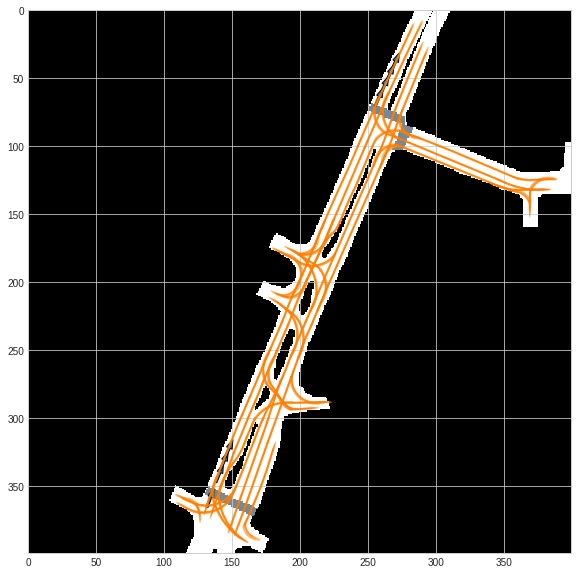

In [42]:
@torch.no_grad()
def local_pose_to_image(local_poses,pose_mask,resolution,img_size,arror_length=None):
    '''local_poses: [T,4] 
    mask: [T]
    '''
    if arror_length is None:
        arror_length=8
    y_m=np.asarray(local_poses[:,1][pose_mask].cpu())
    x_m=np.asarray(local_poses[:,0][pose_mask].cpu())
    img_origin=np.round(np.asarray(img_size)/2).astype(np.int)
    x=img_origin[1]+x_m*resolution
    y=img_origin[0]-y_m*resolution
    yaw=np.asarray((local_poses[:,2][pose_mask]).cpu())
    dy=-np.sin(yaw+np.pi/2)*arror_length
    dx=np.cos(yaw+np.pi/2)*arror_length
    return x,y,dx,dy

from nuscenes.prediction.input_representation.static_layers import *
from nuscenes.prediction.input_representation.combinators import Rasterizer

image_side_length = 2 * max(30,dist+20)
image_side_length_pixels = 400
resolution=image_side_length_pixels/image_side_length
patchbox = get_patchbox(origin[0], origin[1], image_side_length)

angle_in_degrees = angle_of_rotation(origin[2]) * 180 / np.pi

canvas_size = (image_side_length_pixels, image_side_length_pixels)
maps= load_all_maps(helper)
layer_names = ['drivable_area', 'ped_crossing']
masks = maps[map_name].get_map_mask(patchbox, angle_in_degrees, layer_names, canvas_size=canvas_size)
colors = [(255, 255, 255), (119, 136, 153)]
images = []
for mask, color in zip(masks, colors):
    images.append(change_color_of_binary_mask(np.repeat(mask[::-1, :, np.newaxis], 3, 2), color))


lanes=data_test['map_representation']['lane_node_feats'][sample_id].flatten(0,1).clone()
# submask=torch.zeros_like(data_test['map_representation']['lane_node_feats'][sample_id])
# for i in data_test['map_representation']['s_next'][sample_id,0,:-1]:
#     # print(i)
#     submask[0]=1
# lanes*=submask.flatten(0,1)
lanes_mask=data_test['map_representation']['lane_node_feats'][sample_id].flatten(0,1)[:,0].bool()
image = Rasterizer().combine(images)
pose_future_mask=~data_test['target_agent_representation']['future']['mask'][sample_id][:,0].bool()
pose_hist_mask=~data_test['target_agent_representation']['history']['mask'][sample_id][:,0].bool()
xs, ys, dxs, dys=local_pose_to_image(future,pose_future_mask,resolution,canvas_size)
xsh, ysh, dxsh, dysh=local_pose_to_image(hist,pose_hist_mask,resolution,canvas_size)
xsl, ysl, dxsl, dysl=local_pose_to_image(lanes,lanes_mask,resolution,canvas_size,5)
# plt.imshow(image)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.imshow(image)
for x, y, dx, dy in zip(xs, ys, dxs, dys):
    ax.arrow(x, y, dx, dy, width=1.5)
for x, y, dx, dy in zip(xsh, ysh, dxsh, dysh):
    ax.arrow(x, y, dx, dy, width=1.5)
for x, y, dx, dy in zip(xsl, ysl, dxsl, dysl):
    ax.arrow(x, y, dx, dy, width=0.5, color=(1,0.5,0,0.3))
fig.canvas.draw()
# image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# plt.close(fig)
# import matplotlib.image
# matplotlib.image.imsave('train_eval/test/name.png', image_from_plot)



/home/stanliu/.local/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/stanliu/.local/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


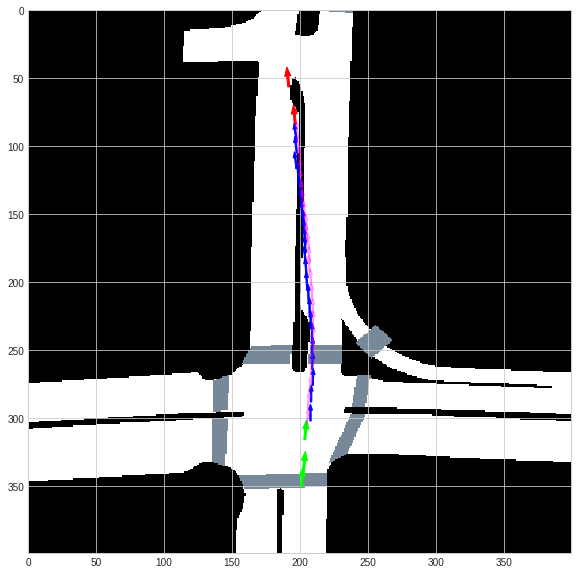

In [37]:
with torch.no_grad():
    predictions=trainer.model(data_test)
    resolution=0.5
    image_side_length = 2 * max(30,dist+20)
    image_side_length_pixels = 400
    resolution=image_side_length_pixels/image_side_length
    patchbox = get_patchbox(origin[0], origin[1], image_side_length)

    angle_in_degrees = angle_of_rotation(origin[2]) * 180 / np.pi

    canvas_size = (image_side_length_pixels, image_side_length_pixels)
    maps= load_all_maps(helper)
    layer_names = ['drivable_area', 'ped_crossing']
    masks = maps[map_name].get_map_mask(patchbox, angle_in_degrees, layer_names, canvas_size=canvas_size)
    colors = [(255, 255, 255), (119, 136, 153)]
    images = []
    for mask, color in zip(masks, colors):
        images.append(change_color_of_binary_mask(np.repeat(mask[::-1, :, np.newaxis], 3, 2), color))

    traj = predictions['refined_traj'][sample_id].squeeze(0)
    yaw = predictions['refined_yaw'][sample_id]
    pred = torch.cat((traj,yaw),-1)
    pose_pred_mask=~(predictions['mask'][sample_id]).bool()
    gt = gt_test['traj'][sample_id]
    image = Rasterizer().combine(images)
    pose_future_mask=~data_test['target_agent_representation']['future']['mask'][sample_id][:,0].bool()
    pose_hist_mask=~data_test['target_agent_representation']['history']['mask'][sample_id][:,0].bool()
    xs, ys, dxs, dys=local_pose_to_image(future,pose_future_mask,resolution,canvas_size)
    xsh, ysh, dxsh, dysh=local_pose_to_image(hist,pose_hist_mask,resolution,canvas_size)
    xsp, ysp, dxsp, dysp=local_pose_to_image(pred,pose_pred_mask,resolution,canvas_size)
    xsg, ysg, dxsg, dysg=local_pose_to_image(gt,pose_pred_mask,resolution,canvas_size)
    # plt.imshow(image)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    # ax.imshow(image)
    for x, y, dx, dy in zip(xs, ys, dxs, dys):
        ax.arrow(x, y, dx, dy, width=1.5, color=(1,0,0,1))
    for x, y, dx, dy in zip(xsh, ysh, dxsh, dysh):
        ax.arrow(x, y, dx, dy, width=1.5, color=(0,1,0,1))
    for x, y, dx, dy in zip(xsp, ysp, dxsp, dysp):
        ax.arrow(x, y, dx, dy, width=1.0, color=(0,0.0,1,1))
    for x, y, dx, dy in zip(xsg, ysg, dxsg, dysg):
        ax.arrow(x, y, dx, dy, width=1.0, color=(1,0,1,0.3))
    ax.imshow(image)

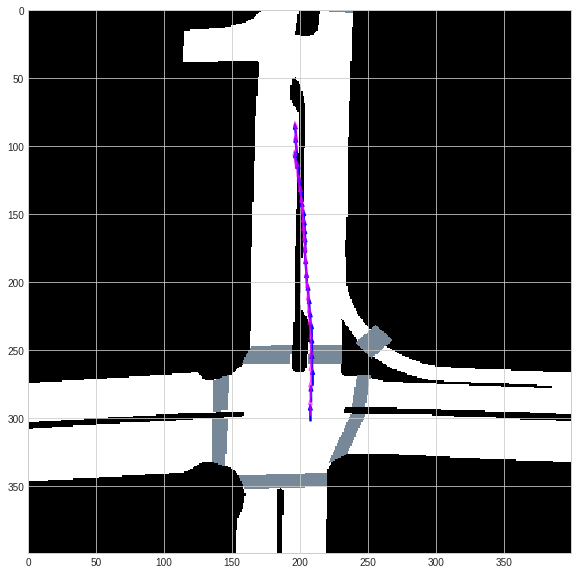

In [16]:
with torch.no_grad():

    resolution=0.5
    image_side_length = 2 * max(30,dist+20)
    image_side_length_pixels = 400
    resolution=image_side_length_pixels/image_side_length
    patchbox = get_patchbox(origin[0], origin[1], image_side_length)

    angle_in_degrees = angle_of_rotation(origin[2]) * 180 / np.pi

    canvas_size = (image_side_length_pixels, image_side_length_pixels)
    maps= load_all_maps(helper)
    layer_names = ['drivable_area', 'ped_crossing']
    masks = maps[map_name].get_map_mask(patchbox, angle_in_degrees, layer_names, canvas_size=canvas_size)
    colors = [(255, 255, 255), (119, 136, 153)]
    images = []
    for mask, color in zip(masks, colors):
        images.append(change_color_of_binary_mask(np.repeat(mask[::-1, :, np.newaxis], 3, 2), color))

    ref_traj = predictions['refined_traj'][sample_id].squeeze(0)
    ref_yaw = predictions['yaw'][sample_id]
    ref_pred = torch.cat((ref_traj,ref_yaw),-1)
    traj = predictions['traj'][sample_id].squeeze(0)
    yaw = predictions['yaw'][sample_id]
    pred = torch.cat((traj,yaw),-1)
    pose_pred_mask=~(predictions['mask'][sample_id]).bool()
    # gt = gt_test['traj'][sample_id]
    image = Rasterizer().combine(images)
    pose_future_mask=~data_test['target_agent_representation']['future']['mask'][sample_id][:,0].bool()
    pose_hist_mask=~data_test['target_agent_representation']['history']['mask'][sample_id][:,0].bool()

    xsp, ysp, dxsp, dysp=local_pose_to_image(ref_pred ,pose_pred_mask,resolution,canvas_size)
    xsg, ysg, dxsg, dysg=local_pose_to_image(pred,pose_pred_mask,resolution,canvas_size)
    # plt.imshow(image)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    # ax.imshow(image)
    for x, y, dx, dy in zip(xsp, ysp, dxsp, dysp):
        ax.arrow(x, y, dx, dy, width=1.0, color=(0,0.0,1,1))
    for x, y, dx, dy in zip(xsg, ysg, dxsg, dysg):
        ax.arrow(x, y, dx, dy, width=1.0, color=(1,0,1,0.5))
    ax.imshow(image)

In [46]:
gt_test['traj'][sample_id].shape

torch.Size([34, 3])

In [5]:
import sys
dists=torch.empty(0)
import train_eval.utils as u
for i,data in enumerate(trainer.tr_dl):
    # torch.cuda.empty_cache()
    # Load data
    sys.stdout.write('processing  %d/%d\r' % (i+1, len(trainer.tr_dl)))
    sys.stdout.flush()
    data = u.send_to_device(u.convert_double_to_float(data))
    data_test=data['inputs']
    traj=data_test['target_agent_representation']['future']['traj'][:,0,:2]
    dist=torch.norm(traj,dim=-1).cpu()
    dists=torch.cat((dists,dist),dim=0)
    # break

tensor(322.3613)


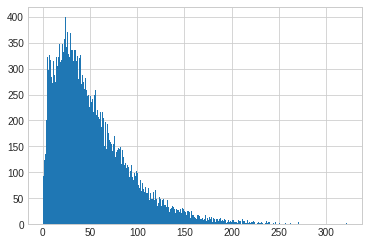

In [6]:
plt.hist(dists,bins=400)
print(torch.max(dists))

In [5]:
data_test.keys()

dict_keys(['instance_token', 'sample_token', 'map_representation', 'surrounding_agent_representation', 'target_agent_representation', 'agent_node_masks'])

In [32]:
data_test['map_representation']['lane_node_masks'].shape

torch.Size([36, 329, 20, 6])

In [66]:
for k,v in data_test['target_agent_representation'].items():
    try:
        print(k)
    except:
        for key,val in v.items():
            print(val.shape)

history
future
concat_motion
time_query


In [13]:
data_test['target_agent_representation']['time_query']['query'].shape

torch.Size([36, 34, 2])

In [9]:
focal=trainer.losses[0]
ade=trainer.losses[1]
# dri_loss=trainer.losses[1]


In [6]:
if trainer.use_teacher_force:
    trainer.model.aggregator.teacher_force=True
    trainer.model.decoder.teacher_force=True
    data_test['gt_traj']=data['ground_truth']['traj']
else:
    trainer.model.aggregator.teacher_force=False
    trainer.model.decoder.teacher_force=False
    data_test['gt_traj']=None

In [14]:
if trainer.pretrain_mlp:
    data_test['gt_traj']=data['ground_truth']['traj']
else:
    data_test['gt_traj']=None   

In [5]:
inputs=data_test
self=trainer.model.encoder
torch.cuda.empty_cache()
lane_node_feats = inputs['map_representation']['lane_node_feats']
lane_node_masks = inputs['map_representation']['lane_node_masks']
lane_node_embedding = self.leaky_relu(self.node_emb(lane_node_feats))
lane_node_enc = self.variable_size_gru_encode(lane_node_embedding, lane_node_masks, self.node_encoder)
lane_node_enc.shape


torch.Size([16, 218, 48])

In [6]:
# test_tensor=torch.arange(10).unsqueeze(0).unsqueeze(-1).repeat(12,1,3)
# start=torch.zeros_like(hist_seq_length)

def get_bidirec_data(input_tensor, start_indices, end_indices, max_length=5):
    """
    Extracts data from a 3D tensor according to start and end indices.

    :param input_tensor: the input tensor of shape (B, T, C)
    :param start_indices: a tensor of shape (B,) containing the start indices for each mini-batch
    :param end_indices: a tensor of shape (B,) containing the end indices for each mini-batch
    :param max_length: the maximum length of the extracted data
    :return: a tensor of shape (B, Q, C), where Q is the maximum length
    """
    # Create a tensor to hold the extracted data
    B, T, C = input_tensor.shape
    Q = max_length
    extracted_data = torch.zeros((B, Q, C), dtype=input_tensor.dtype, device=input_tensor.device)

    # Iterate over each mini-batch and extract the data
    for b in range(B):
        start_index = int(start_indices[b])
        end_index = int(end_indices[b])
        length = end_index - start_index

        # Ensure the length is not greater than the maximum length
        if length > Q:
            length = Q

        # Extract the data
        if length > 0:
            extracted_data[b, :length] = extracted_data[b, :length]+input_tensor[b, start_index:end_index]

    return extracted_data

In [18]:
target_agent_representation=inputs['target_agent_representation']
hist=target_agent_representation['history']['traj']
hist_mask=target_agent_representation['history']['mask']
future=target_agent_representation['future']['traj']
future_mask=target_agent_representation['future']['mask']
concat=target_agent_representation['concat_motion']['traj']
concat_mask=target_agent_representation['concat_motion']['mask']
target_concat_embedding = self.leaky_relu(self.target_concat_emb(concat))
hist_unpacked,future_unpacked=self.get_ugru_enc(concat_mask,target_concat_embedding,hist_mask,future_mask)
target_past_embedding = self.leaky_relu(self.target_past_emb(hist))
target_future_embedding = self.leaky_relu(self.target_fut_emb(future))
# concatenate bi-gru output with original feature 
past_feature=torch.cat((target_past_embedding,hist_unpacked),dim=-1).unsqueeze(1)
future_feature=torch.cat((target_future_embedding,future_unpacked),dim=-1).unsqueeze(1)
target_past_encdoings = self.variable_size_gru_encode(past_feature, hist_mask.unsqueeze(1), self.target_past_enc)
target_future_encdoings = self.variable_size_gru_encode(future_feature, future_mask.unsqueeze(1), self.target_fut_enc)

In [9]:
future

tensor([[[37.0878, 39.8689, -0.7563,  9.8991],
         [33.3429, 36.0024, -0.7563,  9.3992],
         [29.7169, 32.2359, -0.7563,  8.8993],
         [26.0879, 28.4644, -0.7563,  8.3989],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.9533,  2.1810, -0.5935,  4.5011],
         [ 0.8033,  1.7644, -0.5892,  4.0006],
         [ 0.6380,  1.3070, -0.5844,  3.4504],
         [ 0.4762,  1.0205, -0.5801,  2.9494],
         [ 0.3145,  0.7340, -0.5758,  2.4490]],

        [[10.6328, 12.1947, -0.8110,  6.5520],
         [ 7.7385,  9.5716, -0.8110,  5.0021],
         [ 6.8040,  8.7254, -0.8110,  4.5017],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 9.2306, 23.3531, -0.3450,  6.0013],
         [ 7.9353, 19.8809, -0.3537,  5.5014],
         [ 6.6392, 16.4046, -0.3625,  5.0010],
         [ 5.4644, 13.4010, -0.3756,  4.5012],
         [ 4.2886, 10.3973, -0.3887,  4.0012]]], device='cuda:0')

In [12]:
hist

tensor([[[-31.5411, -33.6220,  -0.7738,  -1.9995],
         [-30.6037, -32.8892,  -0.7563,  -1.4996],
         [-29.0822, -31.3574,  -0.7650,  -0.9998],
         [-27.5222, -29.8670,  -0.7738,  -0.4999],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        [[ -0.4176,  -0.8511,  -0.5439,  -2.0001],
         [ -0.3924,  -0.8223,  -0.5471,  -1.5002],
         [ -0.3661,  -0.7925,  -0.5503,  -0.9997],
         [ -0.3408,  -0.7638,  -0.5535,  -0.4999],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        [[-19.7126, -20.8194,  -0.8459,  -1.9497],
         [-15.8182, -17.4355,  -0.8459,  -1.4499],
         [-12.1664, -14.2673,  -0.8459,  -0.9500],
         [ -9.1222, -11.6300,  -0.8459,  -0.4999],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        [[ -8.3237, -15.6913,  -1.0928,  -2.0482],
         [ -7.1268, -14.6498,  -0.9472,  -1.4951],
         [ -5.9987, -13.4049,  -0.7781,  -0.9997],
         [ -5.2174, -12.0321,  -0.6074,  -0.4999],
         [  0.0000,   0.0

In [13]:
nbr_vehicle_feats = inputs['surrounding_agent_representation']['vehicles']
nbr_vehicle_feats = torch.cat((nbr_vehicle_feats, torch.zeros_like(nbr_vehicle_feats[:, :, :, 0:1])), dim=-1)
nbr_vehicle_masks = inputs['surrounding_agent_representation']['vehicle_masks']
nbr_vehicle_embedding = self.leaky_relu(self.nbr_emb(nbr_vehicle_feats))
nbr_vehicle_enc = self.variable_size_gru_encode(nbr_vehicle_embedding, nbr_vehicle_masks, self.nbr_enc)
nbr_ped_feats = inputs['surrounding_agent_representation']['pedestrians']
nbr_ped_feats = torch.cat((nbr_ped_feats, torch.ones_like(nbr_ped_feats[:, :, :, 0:1])), dim=-1)
nbr_ped_masks = inputs['surrounding_agent_representation']['pedestrian_masks']
nbr_ped_embedding = self.leaky_relu(self.nbr_emb(nbr_ped_feats))
nbr_ped_enc = self.variable_size_gru_encode(nbr_ped_embedding, nbr_ped_masks, self.nbr_enc)

In [60]:

# Agent-node attention
nbr_encodings = torch.cat((nbr_vehicle_enc, nbr_ped_enc), dim=1)
queries = self.query_emb(lane_node_enc).permute(1, 0, 2)
keys = self.key_emb(nbr_encodings).permute(1, 0, 2)
vals = self.val_emb(nbr_encodings).permute(1, 0, 2)
attn_masks = torch.cat((inputs['agent_node_masks']['agent']['vehicles'],
                        inputs['agent_node_masks']['agent']['pedestrians']), dim=2)
attn_masks.shape

torch.Size([16, 218, 98])

In [ ]:
att_op, _ = self.a_n_att(queries, keys, vals, attn_mask=attn_masks.bool())
att_op = att_op.permute(1, 0, 2)
lane_node_enc

In [41]:
indication_mask = (~attn_masks.bool())
for i,(mask,output) in enumerate(zip(indication_mask,att_op)):
    if mask.any():
        lane_node_enc[i] = lane_node_enc[i] + output

In [43]:
torch.isnan(lane_node_enc).sum()

tensor(0, device='cuda:0')

In [ ]:

# att_op[torch.isnan(att_op)]=0
# Concatenate with original node encodings and 1x1 conv
lane_node_enc = self.leaky_relu(self.mix(torch.cat((lane_node_enc, att_op), dim=2)))

# GAT layers
adj_mat = self.build_adj_mat(inputs['map_representation']['s_next'], inputs['map_representation']['edge_type'])
for gat_layer in self.gat:
    lane_node_enc += gat_layer(lane_node_enc, adj_mat)

In [64]:
from models.library.blocks import leaky_MLP
args={'node_enc_size':32,'target_agent_enc_size':32}
self.nd_key_emb = nn.Linear(args['node_enc_size'], args['target_agent_enc_size']).cuda()
self.nd_val_emb = nn.Linear(args['node_enc_size'], args['target_agent_enc_size']).cuda()
self.t_n_att = nn.MultiheadAttention(args['target_agent_enc_size'], num_heads=1).cuda()
self.past_mix = leaky_MLP(args['target_agent_enc_size']*2, args['target_agent_enc_size']).cuda()
self.future_mix = leaky_MLP(args['target_agent_enc_size']*2, args['target_agent_enc_size']).cuda()

In [18]:
attn_masks.shape

torch.Size([12, 112, 93])

In [15]:
tgt_queries = torch.cat((target_past_encdoings, target_future_encdoings), dim=1).permute(1, 0, 2)
nd_keys = self.leaky_relu(self.nd_key_emb(lane_node_enc)).permute(1, 0, 2)
nd_vals = self.leaky_relu(self.nd_val_emb(lane_node_enc)).permute(1, 0, 2)
t_n_attn_masks = inputs['agent_node_masks']['target']
t_n_att_op, _ = self.t_n_att(tgt_queries, nd_keys, nd_vals, attn_mask=t_n_attn_masks.bool())
t_n_att_op = t_n_att_op.permute(1, 0, 2)
t_n_att_op[torch.isnan(t_n_att_op)]=0
aug_past_enc=self.mix(torch.cat((target_past_encdoings,t_n_att_op[:,0].unsqueeze(1)),dim=2))
aug_future_enc=self.mix(torch.cat((target_future_encdoings,t_n_att_op[:,1].unsqueeze(1)),dim=2))


In [55]:

# Concatenate with original node encodings and 1x1 conv
# lane_node_enc = self.leaky_relu(self.mix(torch.cat((target_past_encdoings, t_n_att_op[:,0]), dim=2)))

In [16]:
# data['ground_truth']['traj']
map_representation = data_test['map_representation']['image']
mask=data_test['map_representation']['mask']


mask.shape

torch.Size([8, 488, 488])

In [9]:
data_test['map_representation']['image'].shape

torch.Size([12, 3, 488, 488])

In [12]:
traj_hist=data_test['target_agent_representation']

In [ ]:
from models.library.RasterSampler import *
sampler = Sampler(cfg['aggregator_args'],resolution=1.0,apply_mask=True)
nodes_2D=sampler.sample_goals(mask)
mask_under=sampler.sample_mask(mask)

In [ ]:
import matplotlib.pyplot as plt
for idx in range(8):
    surrounding_agents=data_test['surrounding_agent_representation']['image'][idx]
    plt.imshow(map_representation[idx].permute(1,2,0).cpu())
    plt.show()
    # plt.imshow(gs_map[idx,0].cpu())
    # plt.show()
    plt.imshow(surrounding_agents.permute(1,2,0).cpu())
    plt.show()
    # plt.imshow(mask[idx].cpu())
    # plt.show()

In [3]:
import torch
from math import exp
from torch.autograd import Variable
import torch.nn.functional as F
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss#/gauss.sum()
def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 0.8).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window
window=create_window(5, 1)
window


tensor([[[[0.0019, 0.0201, 0.0439, 0.0201, 0.0019],
          [0.0201, 0.2096, 0.4578, 0.2096, 0.0201],
          [0.0439, 0.4578, 1.0000, 0.4578, 0.0439],
          [0.0201, 0.2096, 0.4578, 0.2096, 0.0201],
          [0.0019, 0.0201, 0.0439, 0.0201, 0.0019]]]])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_test['surrounding_agent_representation'][4,:3].permute(1,2,0))
plt.show()
# plt.imshow(test_heatmap[0,0])
# plt.show()
# data['ground_truth']['traj']

In [5]:
data_test['map_representation']['lane_node_feats'].shape

torch.Size([36, 276, 20, 6])

In [ ]:
print('lane_node_feats has shape of ',data_test['map_representation']['lane_node_feats'].shape)
print('lane_node_masks has shape of ',data_test['map_representation']['lane_node_masks'].shape)
print('s_next has shape of ',data_test['map_representation']['s_next'].shape)
print('edge_type has shape of ',data_test['map_representation']['edge_type'].shape)

In [34]:
inputs=data_test
data_test.keys()

dict_keys(['instance_token', 'sample_token', 'map_representation', 'surrounding_agent_representation', 'target_agent_representation', 'agent_node_masks'])

In [ ]:
data_test['surrounding_agent_representation']['pedestrians'][-1]

In [25]:
total_norm=0
for p in trainer.model.parameters():
    
    param_norm = p.grad.data.norm(2)
    if torch.isnan(param_norm):
        print(type(p),p.size())
    total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)

<class 'torch.nn.parameter.Parameter'> torch.Size([384, 128])
<class 'torch.nn.parameter.Parameter'> torch.Size([384])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 128])


In [8]:
trainer.model.encoder.nd_tgt_emb=nn.Linear(32, 36).cuda()

In [7]:
from torch.autograd.profiler import profile
with profile( profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    encodings=trainer.model.encoder(data_test)
print(prof.key_averages().table(sort_by='cpu_time', row_limit=10))

-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::_pack_padded_sequence         1.71%       1.482ms         7.62%       6.603ms     943.264us       2.364ms         2.90%       6.601ms     942.958us         712 b           0 b       1.12 Mb      -1.13 Mb             7  
                      aten::gru         0.38%     333.747us         5.42%     

In [6]:
encodings.keys()

dict_keys(['target_agent_encoding', 'context_encoding'])

In [8]:
inputs=data_test
self=trainer.model.encoder
target_agent_representation=inputs['target_agent_representation']
hist=target_agent_representation['history']['traj']
hist_mask=target_agent_representation['history']['mask']
future=target_agent_representation['future']['traj']
future_mask=target_agent_representation['future']['mask']
concat=target_agent_representation['concat_motion']['traj']
concat_mask=target_agent_representation['concat_motion']['mask']
# concat_indicator = torch.cat((torch.zeros([concat.shape[0],hist.shape[1],1]),torch.ones([concat.shape[0],future.shape[1],1])),1).cuda()

target_past_embedding = self.leaky_relu(self.target_past_emb(hist))
target_future_embedding = self.leaky_relu(self.target_fut_emb(future))

## U-GRU method
if self.motion_enc_type == 'ugru':
    target_concat_embedding = self.leaky_relu(self.target_concat_emb(concat))
    hist_unpacked,future_unpacked=self.get_ugru_enc(concat_mask,target_concat_embedding,hist_mask,future_mask)
    # concatenate bi-gru output with original feature 
    past_feature=torch.cat((target_past_embedding,hist_unpacked),dim=-1).unsqueeze(1)
    future_feature=torch.cat((target_future_embedding,future_unpacked),dim=-1).unsqueeze(1)
    target_past_encdoings = self.variable_size_gru_encode(past_feature, hist_mask.unsqueeze(1), self.target_past_enc)
    target_future_encdoings = self.variable_size_gru_encode(future_feature, future_mask.unsqueeze(1), self.target_fut_enc)
else:
## Baseline method
    target_past_encdoings = self.variable_size_gru_encode(target_past_embedding.unsqueeze(1), hist_mask.unsqueeze(1), self.target_past_enc)
    target_future_encdoings = self.variable_size_gru_encode(target_future_embedding.unsqueeze(1), future_mask.unsqueeze(1), self.target_fut_enc)
if self.map_aggregation:
    # Encode lane nodes
    lane_node_feats = inputs['map_representation']['lane_node_feats']
    lane_node_masks = inputs['map_representation']['lane_node_masks']
    lane_node_embedding = self.leaky_relu(self.node_emb(lane_node_feats))
    lane_node_enc = self.variable_size_gru_encode(lane_node_embedding, lane_node_masks, self.node_encoder)

    # Encode surrounding agents
    nbr_vehicle_feats = inputs['surrounding_agent_representation']['vehicles']
    nbr_vehicle_feats = torch.cat((nbr_vehicle_feats, torch.zeros_like(nbr_vehicle_feats[:, :, :, 0:1])), dim=-1)
    nbr_vehicle_masks = inputs['surrounding_agent_representation']['vehicle_masks']
    nbr_vehicle_embedding = self.leaky_relu(self.nbr_emb(nbr_vehicle_feats))
    nbr_vehicle_enc = self.variable_size_gru_encode(nbr_vehicle_embedding, nbr_vehicle_masks, self.nbr_enc)
    nbr_ped_feats = inputs['surrounding_agent_representation']['pedestrians']
    nbr_ped_feats = torch.cat((nbr_ped_feats, torch.ones_like(nbr_ped_feats[:, :, :, 0:1])), dim=-1)
    nbr_ped_masks = inputs['surrounding_agent_representation']['pedestrian_masks']
    nbr_ped_embedding = self.leaky_relu(self.nbr_emb(nbr_ped_feats))
    nbr_ped_enc = self.variable_size_gru_encode(nbr_ped_embedding, nbr_ped_masks, self.nbr_enc)

    # Agent-node attention
    nbr_encodings = torch.cat((nbr_vehicle_enc, nbr_ped_enc), dim=1)
    queries = self.query_emb(lane_node_enc).permute(1, 0, 2)
    keys = self.key_emb(nbr_encodings).permute(1, 0, 2)
    vals = self.val_emb(nbr_encodings).permute(1, 0, 2)
    attn_masks = torch.cat((inputs['agent_node_masks']['agent']['vehicles'],
                            inputs['agent_node_masks']['agent']['pedestrians']), dim=2)

    att_op, _ = self.a_n_att(queries, keys, vals, attn_mask=attn_masks.bool())
    att_op = att_op.permute(1, 0, 2)
    indication_mask = (~attn_masks.bool())
    nbr_attn_enc=torch.empty([0,lane_node_enc.shape[1],lane_node_enc.shape[2]]).cuda()
    for i,mask in enumerate(indication_mask):
        if mask.any():
            nbr_attn_enc = torch.cat((nbr_attn_enc,att_op[i].unsqueeze(0)),dim=0)
        else:
            nbr_attn_enc = torch.cat((nbr_attn_enc,torch.zeros_like(att_op[i]).unsqueeze(0)),dim=0)
    lane_node_enc=nbr_attn_enc+lane_node_enc

In [11]:
future

tensor([[[ 1.2993e-01,  2.6521e+01,  2.0554e-03,  3.3996e+00],
         [ 1.0115e-01,  2.2675e+01,  2.0554e-03,  2.9003e+00],
         [ 7.2017e-02,  1.8825e+01,  2.0554e-03,  2.4004e+00],
         [ 4.8416e-02,  1.5741e+01,  2.0554e-03,  2.0001e+00],
         [ 1.9278e-02,  1.1890e+01,  2.0554e-03,  1.5002e+00]],

        [[ 1.5213e+00,  8.6999e+01,  1.0844e-02,  1.0501e+01],
         [ 1.5385e+00,  8.4194e+01,  2.0477e-02,  1.0100e+01],
         [ 1.5643e+00,  7.9993e+01,  3.4907e-02,  9.5007e+00],
         [ 1.3732e+00,  7.5335e+01,  3.4907e-02,  8.9994e+00],
         [ 1.1634e+00,  7.0223e+01,  1.7453e-02,  8.4492e+00]],

        [[ 1.5276e+00,  8.2230e+01,  1.0844e-02,  9.9002e+00],
         [ 1.5707e+00,  7.5224e+01,  3.4907e-02,  8.9002e+00],
         [ 1.3795e+00,  7.0566e+01,  3.4907e-02,  8.3989e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 3.8879e-01,  3.5573e+01, -3.4939e-03, 

In [ ]:
bool_indicartor=(~inputs['agent_node_masks']['target'].bool()).any(dim=-1)
bool_indicartor


In [15]:
future[-3]

tensor([[ 1.3818e+00,  7.2346e+01, -1.7453e-02,  1.1450e+01],
        [ 1.1145e+00,  6.6284e+01, -1.7453e-02,  1.0450e+01],
        [ 7.9173e-01,  6.0126e+01, -1.7453e-02,  9.4999e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0')

In [11]:
for k,v in encodings['target_agent_encoding'].items():
    try:
        print(k)
        print(' ',v.shape)
    except:
        for key,val in v.items():
            print(key)
            print(' ',val.shape)

hist
  torch.Size([12, 1, 32])
future
  torch.Size([12, 1, 32])
time_query
query
  torch.Size([12, 34, 2])
mask
  torch.Size([12, 34, 2])


In [23]:
self=trainer.model.aggregator
time_dim=32
self.tq_embder=nn.Sequential(nn.Linear(2,time_dim),
                               nn.LeakyReLU()).cuda()
self.tq_attn=nn.MultiheadAttention(time_dim, num_heads=1).cuda()
target_representation=encodings['target_agent_encoding']
target_hist=target_representation['hist']
target_future=target_representation['future']
time_query=target_representation['time_query']['query']
mask=target_representation['time_query']['mask']
q_t_attn_masks = mask.bool()
query_emb=self.tq_embder(time_query).permute(1,0,2)
concat_kv=torch.cat((target_hist,target_future),dim=1).permute(1,0,2)
t_q_att_op, _ = self.tq_attn(query_emb, concat_kv, concat_kv, attn_mask=q_t_attn_masks.bool())
t_q_att_op[torch.isnan(t_q_att_op)]=0

In [25]:
t_q_att_op=t_q_att_op.transpose(0,1)
t_q_att_op.shape

torch.Size([12, 34, 32])

In [15]:
encodings.keys()

dict_keys(['target_agent_encoding', 'context_encoding'])

In [8]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    agg_feat=trainer.model.aggregator(encodings)
print(prof.key_averages().table(sort_by="cpu_time", row_limit=10))
torch.cuda.empty_cache()
# connectivities=agg_feat['node_connectivity']
# mask_map=agg_feat['under_sampled_mask']
# init=agg_feat['initial_states']
# print(connectivities.requires_grad)
# print(mask_map.requires_grad)

-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           aten::repeat         4.24%     124.743us        12.77%     376.010us     188.005us     148.479us         5.24%     376.832us     188.416us           0 b           0 b     144.00 Kb           0 b             2  
           aten::matmul         3.64%     107.113us        19.01%     559.574us     139.894us     186.562us   

In [18]:
agg_encoding=agg_feat
self=trainer.model.decoder
query=agg_encoding['query']
traj=self.traj_decoder(query).unsqueeze(1)
yaw=self.yaw_decoder(query)
mask=agg_encoding['mask'][:,:,0]
predictions = {'traj': traj, 'yaw': yaw, 'mask': mask}
if 'endpoints' in agg_encoding:
    endpoints_query=agg_encoding['endpoints']
    endpoints_coords=self.traj_decoder(endpoints_query).unsqueeze(1)
    endpoints_yaw=self.yaw_decoder(endpoints_query)
    predictions['endpoint_traj']=endpoints_coords
    predictions['endpoint_yaw']=endpoints_yaw
if 'refine_input' in agg_encoding:
    base_info=agg_encoding['refine_input']['traj'].clone()
    refine_mask=agg_encoding['refine_input']['mask']
    fill_in_mask=torch.isinf(base_info)
    fill_in_vals=torch.cat((traj.clone().squeeze(1),yaw),-1)
    extract_mask=(1-(mask.clone().unsqueeze(-1).repeat(1,1,3))).bool()
    base_info[fill_in_mask]=fill_in_vals[extract_mask]
    

In [26]:
traj_ctrs=base_info[:,:,:2]
traj_ctrs.shape

torch.Size([16, 44, 2])

In [28]:
mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [7]:
self=trainer.model.decoder
agg_encoding=agg_feat
query=agg_encoding['query']
traj=self.traj_decoder(query).unsqueeze(1)
yaw=self.yaw_decoder(query)

In [7]:
tq_self_attn = nn.MultiheadAttention(48, 1).cuda()
query_emb = nn.Linear(48, 48).cuda()
key_emb = nn.Linear(48, 48).cuda()
val_emb = nn.Linear(48, 48).cuda()



In [8]:
agg_encoding=agg_feat
attn_mask=agg_encoding['mask'][:,:,0].unsqueeze(-1).transpose(1,2).repeat(1,agg_encoding['mask'].shape[1],1).bool()
query=query_emb(agg_encoding['query']).transpose(0,1)
key=key_emb(agg_encoding['query']).transpose(0,1)
val=val_emb(agg_encoding['query']).transpose(0,1)
att_op, _ = tq_self_attn(query, key, val, attn_mask=attn_mask.bool())
att_op=att_op.transpose(0,1)

aug_query=torch.cat((agg_encoding['query'],att_op),dim=-1)

In [9]:
from models.library.blocks import *
traj_decoder=nn.Sequential(leaky_MLP(96,48),
                            nn.Linear(48,2)).cuda()
yaw_decoder=nn.Sequential(leaky_MLP(96,48),
                            nn.Linear(48,1)).cuda()

traj=traj_decoder(aug_query).unsqueeze(1)
yaw=yaw_decoder(aug_query)
mask=agg_encoding['mask'][:,:,0]

predictions = {'traj': traj, 'yaw': yaw, 'mask': mask}

In [8]:
print(agg_feat.keys())
# print(agg_feat['node_connectivity'].shape)
# inputs=agg_feat
# attn_output_weights = inputs['node_connectivity']
# print(attn_output_weights[0].shape)
# init_states=inputs['initial_states']
# target_encodings = inputs['target_encodings']
# map_feature=inputs['feature'].permute(0,2,3,1) 
# mask=inputs['under_sampled_mask']  

# print(agg_feat['node_connectivity'].shape)
# print((agg_feat['initial_states'].indices().nelement() * agg_feat['initial_states'].indices().element_size() + agg_feat['initial_states'].values().nelement() *agg_feat['initial_states'].values().element_size()) / 1024**2)

dict_keys(['query', 'mask'])


In [ ]:
(~data_test['agent_node_masks']['target'].bool()).any(-1)

In [9]:

with profile( use_cuda=True,profile_memory=True, record_shapes=True) as prof:
    predictions=trainer.model.decoder(agg_feat)
print(prof.key_averages().table(sort_by="cpu_time", row_limit=10))
# print(predictions['pred'].element_size() * predictions['pred'].nelement()/ 1024**2)
# pred=predictions['pred'].to_sparse()
# print(pred.element_size() * pred.nelement()/ 1024**2)

# print((pred.indices().nelement() * pred.indices().element_size() + pred.values().nelement() * pred.values().element_size()) / 1024**2)

-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::_pack_padded_sequence         6.21%       4.390ms         7.57%       5.356ms       5.356ms       4.607ms         6.77%       5.357ms       5.357ms         264 b           0 b     116.00 Kb    -117.50 Kb             1  
                      aten::gru         0.23%     161.235us         3.69%     

In [8]:
from models.library.blocks import Att

traj=predictions['traj'].squeeze(1)
traj_mask=predictions['mask']
lane_enc=encodings['context_encoding']['combined'] #32
lane_mask=encodings['context_encoding']['combined_masks']
lane_ctrs=data_test['map_representation']['lane_ctrs']
query = agg_feat['query'] #48
map_agg = Att(n_agt=48,n_ctx=32).cuda()

In [9]:

agt_idcs=[]
agt_ctrs=[]
ctx_idcs=[]
ctx_ctrs=[]
agt_mask=[]
for batch_id,mask in enumerate(traj_mask):
    agt_idcs.append(torch.arange(traj.shape[1],device=traj.device).long())
    agt_ctrs.append(traj[batch_id])
    ctx_idcs.append(torch.arange(lane_enc.shape[1],device=lane_enc.device).long())
    ctx_ctrs.append(lane_ctrs[batch_id])
    agt_mask.append(traj_mask[batch_id])

In [14]:
map_enc=map_agg.forward(agts=query.flatten(0,1), agt_idcs=agt_idcs, agt_ctrs=agt_ctrs, ctx=lane_enc.flatten(0,1), ctx_idcs=ctx_idcs, ctx_ctrs=ctx_ctrs, dist_th=20,agt_mask=agt_mask)


torch.Size([1088, 48])

In [15]:
map_enc=map_enc.view(query.shape)
query=torch.cat((map_enc,traj),-1)

torch.Size([32, 34, 48])

In [ ]:
mask=agg_feat['mask'][:,:,0]

In [10]:
yaw = predictions['yaw'].squeeze(-1)
yaw_gt = gt_test['traj'][:,:,-1] if type(gt_test) == dict else gt_test[:,:,-1]

# Useful params
batch_size = yaw.shape[0]
sequence_length = yaw.shape[1]

# Masks for variable length ground truth trajectories
masks = predictions['mask'] if type(predictions) == dict and 'mask' in predictions.keys() \
    else torch.zeros(batch_size, sequence_length).to(yaw.device)
indices=torch.abs(yaw-yaw_gt)>(3.14159/2)
multipliers=torch.abs(yaw-yaw_gt)//(3.14159/2)
larger_inds=(yaw_gt>yaw)*indices
smaller_inds=(yaw_gt<yaw)*indices
yaw_gt[larger_inds]-=((3.14159/2)*multipliers[larger_inds])
yaw_gt[smaller_inds]+=((3.14159/2)*multipliers[smaller_inds])

errs=torch.sum(torch.abs(yaw-yaw_gt)*(1-masks),dim=1)/torch.sum((1-masks),dim=1)

In [ ]:
((3.14159/2)*multipliers[larger_inds])

In [8]:
self=trainer.model.decoder
inputs=agg_feat
if type(inputs) is torch.Tensor:
    agg_encoding = inputs
else:
    agg_encoding = inputs['agg_encoding']
    if 'under_sampled_mask' in inputs:
        mask=inputs['under_sampled_mask']
    else:
        mask=None
    
if self.output_traj:
    target_encodings = inputs['target_encodings']
if 'traj_feature' in inputs:
    target_encodings = inputs['traj_feature']
predictions=self.decoding_net(agg_encoding)

In [9]:
map_feature=agg_encoding.flatten(2).permute(2,0,1)
# nodes_2D=get_index(predictions[:,-1].unsqueeze(1),mask,self.H,self.W)
dense_pred=predictions[:,-1].unsqueeze(1)
endpoints,confidences = self.endpoint_sampler(dense_pred)
endpoints=endpoints.long()
concat_feature=torch.empty([0,self.num_target,self.feature_dim],device=predictions.device)
x_coord,y_coord=torch.meshgrid(torch.arange(self.map_extent[-1],self.map_extent[-2],-self.resolution)-self.resolution/2, ##### SHould be changed when image size changes
                                torch.arange(self.map_extent[0],self.map_extent[1],self.resolution)+self.resolution/2)
indices=torch.cat([y_coord.unsqueeze(-1),x_coord.unsqueeze(-1)],dim=-1).to(predictions.device)

In [12]:
for batch_idx in range(len(dense_pred)):
    diff = (indices[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]]).float()
    feature=torch.cat([self.diff_encoder(diff),target_encodings[batch_idx].repeat(self.endpoint_sampler._n_targets,1)],dim=-1).unsqueeze(0)
    concat_feature=torch.cat([concat_feature,feature],dim=0)

In [12]:
print(len(agg_feat['node_connectivity']))
print(agg_feat['under_sampled_mask'].shape)

torch.Size([16, 59536])


In [8]:
agg_encoding = agg_feat['agg_encoding']
mask=agg_feat['under_sampled_mask']

In [10]:
agg_feat.keys()

dict_keys(['agg_encoding', 'under_sampled_mask', 'target_encodings', 'traj_feature', 'gt_traj'])

In [13]:
agg_feat['target_encodings'].sum(-1)


tensor([ 4.1723e-06,  2.8610e-06, -1.9073e-06, -3.3379e-06,  3.3379e-06,
         0.0000e+00, -2.1458e-06,  5.2452e-06, -2.8610e-06,  1.4305e-06,
         9.5367e-07,  2.3842e-06,  2.8610e-06, -9.5367e-07, -3.4571e-06,
         1.6689e-06], device='cuda:0', grad_fn=<SumBackward1>)

In [11]:
self=trainer.model.decoder
print(self.decoding_net)
x=agg_encoding
for i,layer in enumerate(self.decoding_net):
    x=layer(x)
predictions=self.sigmoid(x)


ModuleList(
  (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(16, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
)


In [12]:
focal=trainer.losses[0]
traj_gt = gt_test['traj']
mask_da=mask
_,gs_map=focal.generate_gtmap(traj_gt,mask_da)

In [ ]:
import matplotlib.pyplot as plt
query_images=predictions[:,-1].detach().cpu()
gt_image=torch.clamp(gs_map.sum(dim=1),max=1.0).detach().cpu()
query_num=cfg['batch_size']
fig, ax = plt.subplots(query_num, 2, figsize=(10, 40))
fig.tight_layout()
for i in range(query_num):
    ax[i, 0].imshow(query_images[i])
    ax[i, 0].set_title(i)
    ax[i, 1].imshow(gt_image[i])

In [22]:
focal.compute({'pred': predictions,'mask': mask},gt_test)

tensor(20327.2539, device='cuda:0', grad_fn=<DivBackward0>)

In [10]:
self = trainer.model.aggregator
# mask=agg_feat['under_sampled_mask']
# feature=agg_feat['node_connectivity']
# init_pos=torch.zeros([self.H,self.W],device=feature[0].device)
# init_pos[self.compensation[0],self.compensation[1]]=1
### Goes to aggregator

In [10]:
target_agent_enc = encodings['target_agent_encoding']
context_enc = encodings['context_encoding']
if context_enc['combined'] is not None:
    combined_enc, map_mask = context_enc['combined'], context_enc['map_masks'].bool()
else:
    combined_enc, _ = self.get_combined_encodings(context_enc)

augmented_target_agent_enc = target_agent_enc.unsqueeze(2).unsqueeze(3).repeat(1,1,combined_enc.shape[-2],combined_enc.shape[-1])
concatenated_encodings=torch.cat([combined_enc,augmented_target_agent_enc],dim=1)
context_encoding = self.dim_reduction_block(concatenated_encodings)##Fuse agent feat with map feat by compressing the dimension (actually is linear layer)
augmented_encoding = self.transpose_conv(context_encoding)
augmented_encoding = augmented_encoding + self.pos_enc(augmented_encoding)
context_encoding = context_encoding.view(context_encoding.shape[0], context_encoding.shape[1], -1)## [Batch number, channel, H*W]
context_encoding = context_encoding.permute(0, 2, 1)## [Batch number, H*W, channel]

nodes_2D=self.sampler.sample_goals().repeat(context_encoding.shape[0],1,1).type(torch.float32)
torch.cuda.empty_cache()
query = self.query_emb(nodes_2D).permute(1,0,2)
keys = self.key_emb(context_encoding).permute(1, 0, 2)
vals = self.val_emb(context_encoding).permute(1, 0, 2)
mask_map=(self.sampler.sample_mask(map_mask))
if self.apply_mask:
    
    attn_mask=~mask_map.unsqueeze(-1).repeat(self.num_heads,1,context_encoding.shape[1])
    attn_output, _ = self.mha(query, keys, vals, attn_mask=attn_mask)
    attn_output[torch.isnan(attn_output)]=0
else:
    attn_output, _ = self.mha(query, keys, vals)
torch.cuda.empty_cache()
op = attn_output.permute(1,0,2)
op = op.view(op.shape[0],self.sampler.H,self.sampler.W,-1)
# op = torch.cat((target_agent_enc, op), dim=-1)
if self.conv:
    op=self.final_convs(op.permute(0,3,1,2))
    op=op+self.pos_enc(op)
torch.cuda.empty_cache()

### Desired shape for fold function
$$[B,H*W,conv\_kernel^2]$$

### TODO
1. Get reduced feature with shape $[B,num\_valid\_nodes,conv\_kernel^2,channel]$
2. Applied MLP on reduced feature and get `connectivity` with shape $[B,num\_valid\_nodes,conv\_kernel^2,1]$
3. Recover the reduced `connectivity` to full connectivity with shape $[B,H*W,conv\_kernel^2]$


In [11]:
def get_unfolded_feature(feature,mask,augmented_encoding):
        ## Input shape B,C,H,W
    kernel=self.conv_kernel
    # diff=self.get_diff().to(feature.device)
    # diff_encoding=self.diff_encoder(diff.view(2,-1).permute(1,0))
    torch.cuda.empty_cache()
    unfold = nn.Unfold(kernel_size=(kernel, kernel), dilation=1, padding=kernel//2, stride=(1, 1))
    unfolded=unfold(feature).permute(0,2,1)
    unfolded=(unfolded.view(feature.shape[0],self.H,self.W,-1,self.conv_kernel**2)[:,:-(self.source_row-self.center_row)]).transpose(-1,-2)
    # unfolded=torch.cat((unfolded,diff_encoding.repeat(unfolded.shape[0],unfolded.shape[1],unfolded.shape[2],1,1)),dim=-1)#.view(unfolded_feature.shape[0],unfolded_feature.shape[1],unfolded_feature.shape[2],-1)
    unfolded=unfolded.view(unfolded.shape[0],unfolded.shape[1]*unfolded.shape[2],self.conv_kernel**2,unfolded.shape[-1])## B*Number of slided window,kernel_size**2, channel
    # target_mask=mask.view(mask.shape[0],self.H,self.W)[:,:-(self.source_row-self.center_row)].view(mask.shape[0],-1)
    # unfolded_feature=unfolded_feature.view(unfolded_feature.shape[0],unfolded_feature.shape[1],channel,kernel**2)
    # current_node_feat=feature[:,:,(self.source_row-self.center_row):].view(feature.shape[0],channel,-1).permute(0,2,1)## B,Number of slided window, channel
    source_mask=mask.view(mask.shape[0],self.H,self.W)[:,(self.source_row-self.center_row):].view(mask.shape[0],-1)
    augmented_encoding=augmented_encoding.permute(0,2,3,1)[:,(self.source_row-self.center_row):]
    augmented_encoding=augmented_encoding.view(augmented_encoding.shape[0],-1,augmented_encoding.shape[-1]).unsqueeze(-2)
    # unfolded_feature=(unfolded_feature*mask.unsqueeze(-1)).to_sparse()
    # current_node_feat=(current_node_feat*mask.unsqueeze(-1)).to_sparse()
    summed_feat=torch.zeros([0,self.conv_kernel**2,augmented_encoding.shape[-1]],device=feature.device)
    for idx,batch in enumerate(unfolded):
        summed_feat=torch.cat((summed_feat,(batch+augmented_encoding[idx])[source_mask[idx]]),dim=0)
    # source_mask=torch.cat((source_mask,torch.zeros([mask.shape[0],mask.shape[-1]-source_mask.shape[-1]],device=mask.device)),dim=-1)
    # source_feat=(current_node_feat.unsqueeze(-2).repeat(1,1,self.conv_kernel**2,1)*source_mask).view(-1,channel).to_sparse()
    # target_feat=(unfolded*source_mask).view(-1,unfolded.shape[-1]).to_sparse()
    # torch.cuda.empty_cache()
    # concat_feature=torch.cat((target_feat,source_feat),dim=-1)

    return summed_feat,source_mask

In [65]:
def fake_unfold(feature,mask,augmented_encoding):
    points=torch.cat((self.compensation.unsqueeze(0),torch.Tensor([[186,113],[203,129]]).cuda()),dim=0).long()
    ind0=points[:,0]-(self.source_row-self.center_row)
    ind1=points[:,1]
    channel=augmented_encoding.shape[1]
    B=feature.shape[0]
    torch.cuda.empty_cache()
    unfolded=torch.zeros([B,self.H,self.W,self.conv_kernel**2,channel],device=feature.device)
    unfolded[:,ind0,ind1]=1
    unfolded=unfolded[:,:-(self.source_row-self.center_row)]
    torch.cuda.empty_cache()
    
    unfolded=unfolded.view(unfolded.shape[0],unfolded.shape[1]*unfolded.shape[2],self.conv_kernel**2,unfolded.shape[-1])
    source_mask=mask.view(mask.shape[0],self.H,self.W)[:,(self.source_row-self.center_row):].view(mask.shape[0],-1)
    summed_feat=torch.zeros([0,self.conv_kernel**2,channel],device=feature.device)
    for idx,batch in enumerate(unfolded):
        summed_feat=torch.cat((summed_feat,batch[source_mask[idx]]),dim=0)
    return summed_feat,source_mask

In [15]:
torch.cuda.empty_cache()

In [13]:
mask=mask_map.view(mask_map.shape[0],self.H,self.W).clone()
mask[:,:(self.source_row-self.center_row)]=False
mask=mask.view(mask_map.shape[0],-1)

In [14]:
summed_feat,source_mask=get_unfolded_feature(op,mask,augmented_encoding)
# summed_feat,source_mask=fake_unfold(op,mask,augmented_encoding)
# connectivities=self.concat_feat(source_feat,target_feat,diff)
torch.cuda.empty_cache()

In [15]:
print(summed_feat.shape)
self.deocde_block

torch.Size([50009, 361, 36])


Sequential(
  (0): Linear(in_features=36, out_features=18, bias=True)
  (1): LayerNorm()
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=18, out_features=9, bias=True)
  (4): LayerNorm()
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=9, out_features=1, bias=True)
)

In [16]:
connectivity=self.softmax(self.deocde_block(summed_feat).squeeze(-1))
# connectivity=summed_feat[:,:,0].squeeze(-1)
unfolded_base=torch.zeros(mask.shape[0],self.H*self.W,self.conv_kernel**2,device=op.device)
indices=torch.nonzero(mask)
ind0=indices[:,0]
ind1=indices[:,1]
unfolded_base[ind0,ind1]=connectivity
torch.cuda.empty_cache()


In [17]:
self=trainer.model.aggregator
init_pos=torch.zeros([self.H,self.W],device=connectivity.device)
init_pos[self.compensation[0],self.compensation[1]]=1
init_states=init_pos.repeat(mask.shape[0],1,1).view(mask.shape[0],-1).unsqueeze(-1)
prev_states=init_states.clone()
fold=nn.Fold(output_size=(self.H, self.W), kernel_size=(self.conv_kernel, self.conv_kernel), padding=self.conv_kernel//2, dilation=1, stride=(1, 1))

In [18]:
self=trainer.model.decoder
predictions=torch.empty([init_states.shape[0],0,self.H,self.W],device=unfolded_base.device)
for step in range(self.horizon):
    unfolded_map=(prev_states*unfolded_base).transpose(-1,-2)
    prob_map=torch.cat((fold(unfolded_map)[:,:,5:],torch.zeros([mask.shape[0],1,5,self.W],device=mask.device)),dim=2)
    predictions=torch.cat((predictions,prob_map),dim=1)
    # prev_map=torch.cat((prob_map[:,:,5:],torch.zeros([prob_map.shape[0],1,5,self.W],device=prob_map.device)),dim=2)
    prev_states=prob_map.view(init_states.shape[0],self.H*self.W,1)

In [29]:

pad_mask=((agg_feat['under_sampled_mask'].clone().view(mask.shape[0],self.H,self.W))[:,(self.source_row-self.center_row):]).view(mask.shape[0],-1)
unfold_base=torch.zeros([1,self.conv_kernel**2,(self.source_row-self.center_row)*self.W],device=feature[0].device)
unfold_feature=torch.zeros([0,self.conv_kernel**2,self.H*self.W],device=feature[0].device)
for batch_id,batch in enumerate(pad_mask):
    unfold_batch=unfold_base.clone()
    valid_count=0
    for node_id,node_validity in enumerate(batch):
        if node_validity:
            unfold_batch=torch.cat((unfold_batch,feature[batch_id][valid_count].view(1,-1,1)),dim=-1)
            valid_count+=1
        else:
            unfold_batch=torch.cat((unfold_batch,torch.zeros([1,self.conv_kernel**2,1],device=feature[0].device)),dim=-1)
    unfold_feature=torch.cat((unfold_feature,unfold_batch),dim=0)
    

In [10]:
def get_next(prev_states,feature,mask,indices):
    # unfold_base=torch.zeros([1,self.conv_kernel**2,(self.source_row-self.center_row)*self.W],device=feature[0].device)
    # unfold_feature=torch.zeros([0,self.conv_kernel**2,self.H*self.W],device=feature[0].device)
    unfold_base=torch.zeros([len(feature),self.conv_kernel**2,self.H*self.W],device=feature[0].device)
    for node_idx in indices:
        ## Get valid count
        if mask[node_idx[0],node_idx[1]]==True:
            valid_count=mask[node_idx[0],:node_idx[1]+1].sum().long()
            unfold_base[node_idx[0],:,node_idx[1]-self.W*(self.source_row-self.center_row)]=unfold_base[node_idx[0],:,node_idx[1]-self.W*(self.source_row-self.center_row)]+feature[node_idx[0]][valid_count-1]*prev_states[node_idx[0],node_idx[1]]
    fold=nn.Fold(output_size=(self.H, self.W), kernel_size=(self.conv_kernel, self.conv_kernel), padding=self.conv_kernel//2, dilation=1, stride=(1, 1))
    return fold(unfold_base)

In [11]:
### Goes to decoder
self.horizon=12
predictions=torch.empty([len(feature),0,self.H,self.W],device=feature[0].device)
prev_states=init_pos.repeat([len(feature),1,1])
mask_filtered=mask.clone().view(mask.shape[0],self.H,self.W)
mask_filtered[:,:(self.source_row-self.center_row)]=False
for t in range(self.horizon):
    # prev_states[prev_states<1e-5]=0
    indices=torch.nonzero(prev_states.view(len(feature),-1))
    next_states=get_next(prev_states.view(len(feature),-1),feature,mask_filtered.view(mask.shape[0],-1),indices)
    # print(next_states.shape)
    predictions=torch.cat((predictions,next_states),dim=1)
    prev_states=next_states

In [12]:
predictions=self.softmax(predictions.view(predictions.shape[0],predictions.shape[1],-1)).view(predictions.shape[0],predictions.shape[1],self.H,self.W)

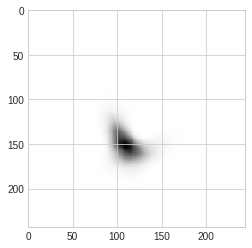

In [26]:
plt.imshow(predictions[1,-1].squeeze(0).detach().cpu())
plt.show()

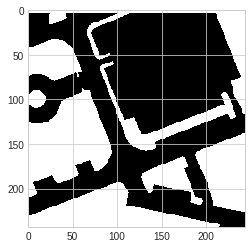

In [25]:
plt.imshow(mask[1].view(244,244).detach().cpu())
plt.show()

In [9]:

self=trainer.model.decoder


In [ ]:
# test_feat=op.view(op.shape[0],op.shape[1],-1).permute(0,2,1)
torch.cuda.empty_cache()
inputs=agg_feat


In [11]:
if type(inputs) is torch.Tensor:
    agg_encoding = inputs
else:
    agg_encoding = inputs['agg_encoding']
    if 'under_sampled_mask' in inputs:
        mask=inputs['under_sampled_mask'].to(agg_encoding.device)
    else:
        mask=None
if self.output_traj:
    target_encodings = inputs['target_encodings']
context_encoding = agg_encoding + self.pos_enc(agg_encoding)

In [12]:
torch.cuda.empty_cache()
context_encoding = context_encoding.view(context_encoding.shape[0], context_encoding.shape[1], -1)
feature = context_encoding.permute(0, 2, 1).unsqueeze(1).repeat(1,self.horizon,1,1)
x=self.decoding_net(feature).view(feature.shape[0],self.horizon,self.H,self.W)
torch.cuda.empty_cache()
predictions=self.sigmoid(x)

In [ ]:
inputs = agg_feat
if type(inputs) is torch.Tensor:
    agg_encoding = inputs
else:
    agg_encoding = inputs['agg_encoding']
    if 'under_sampled_mask' in inputs:
        mask=inputs['under_sampled_mask']
    else:
        mask=None
if self.output_traj:
    target_encodings = inputs['target_encodings']
time_querys=torch.cat((self.querys_embedder(self.time_steps),self.time_steps),dim=-1).repeat(agg_encoding.shape[0],1,1).unsqueeze(2)

In [9]:
predictions.keys()

dict_keys(['pred', 'mask', 'traj', 'probs', 'endpoints'])

In [11]:
sum=predictions['pred'].flatten(1).mean(dim=-1)
sum

torch.Size([16, 1, 968, 968])

In [10]:
predictions['pred'].shape

torch.Size([16, 1, 242, 242])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


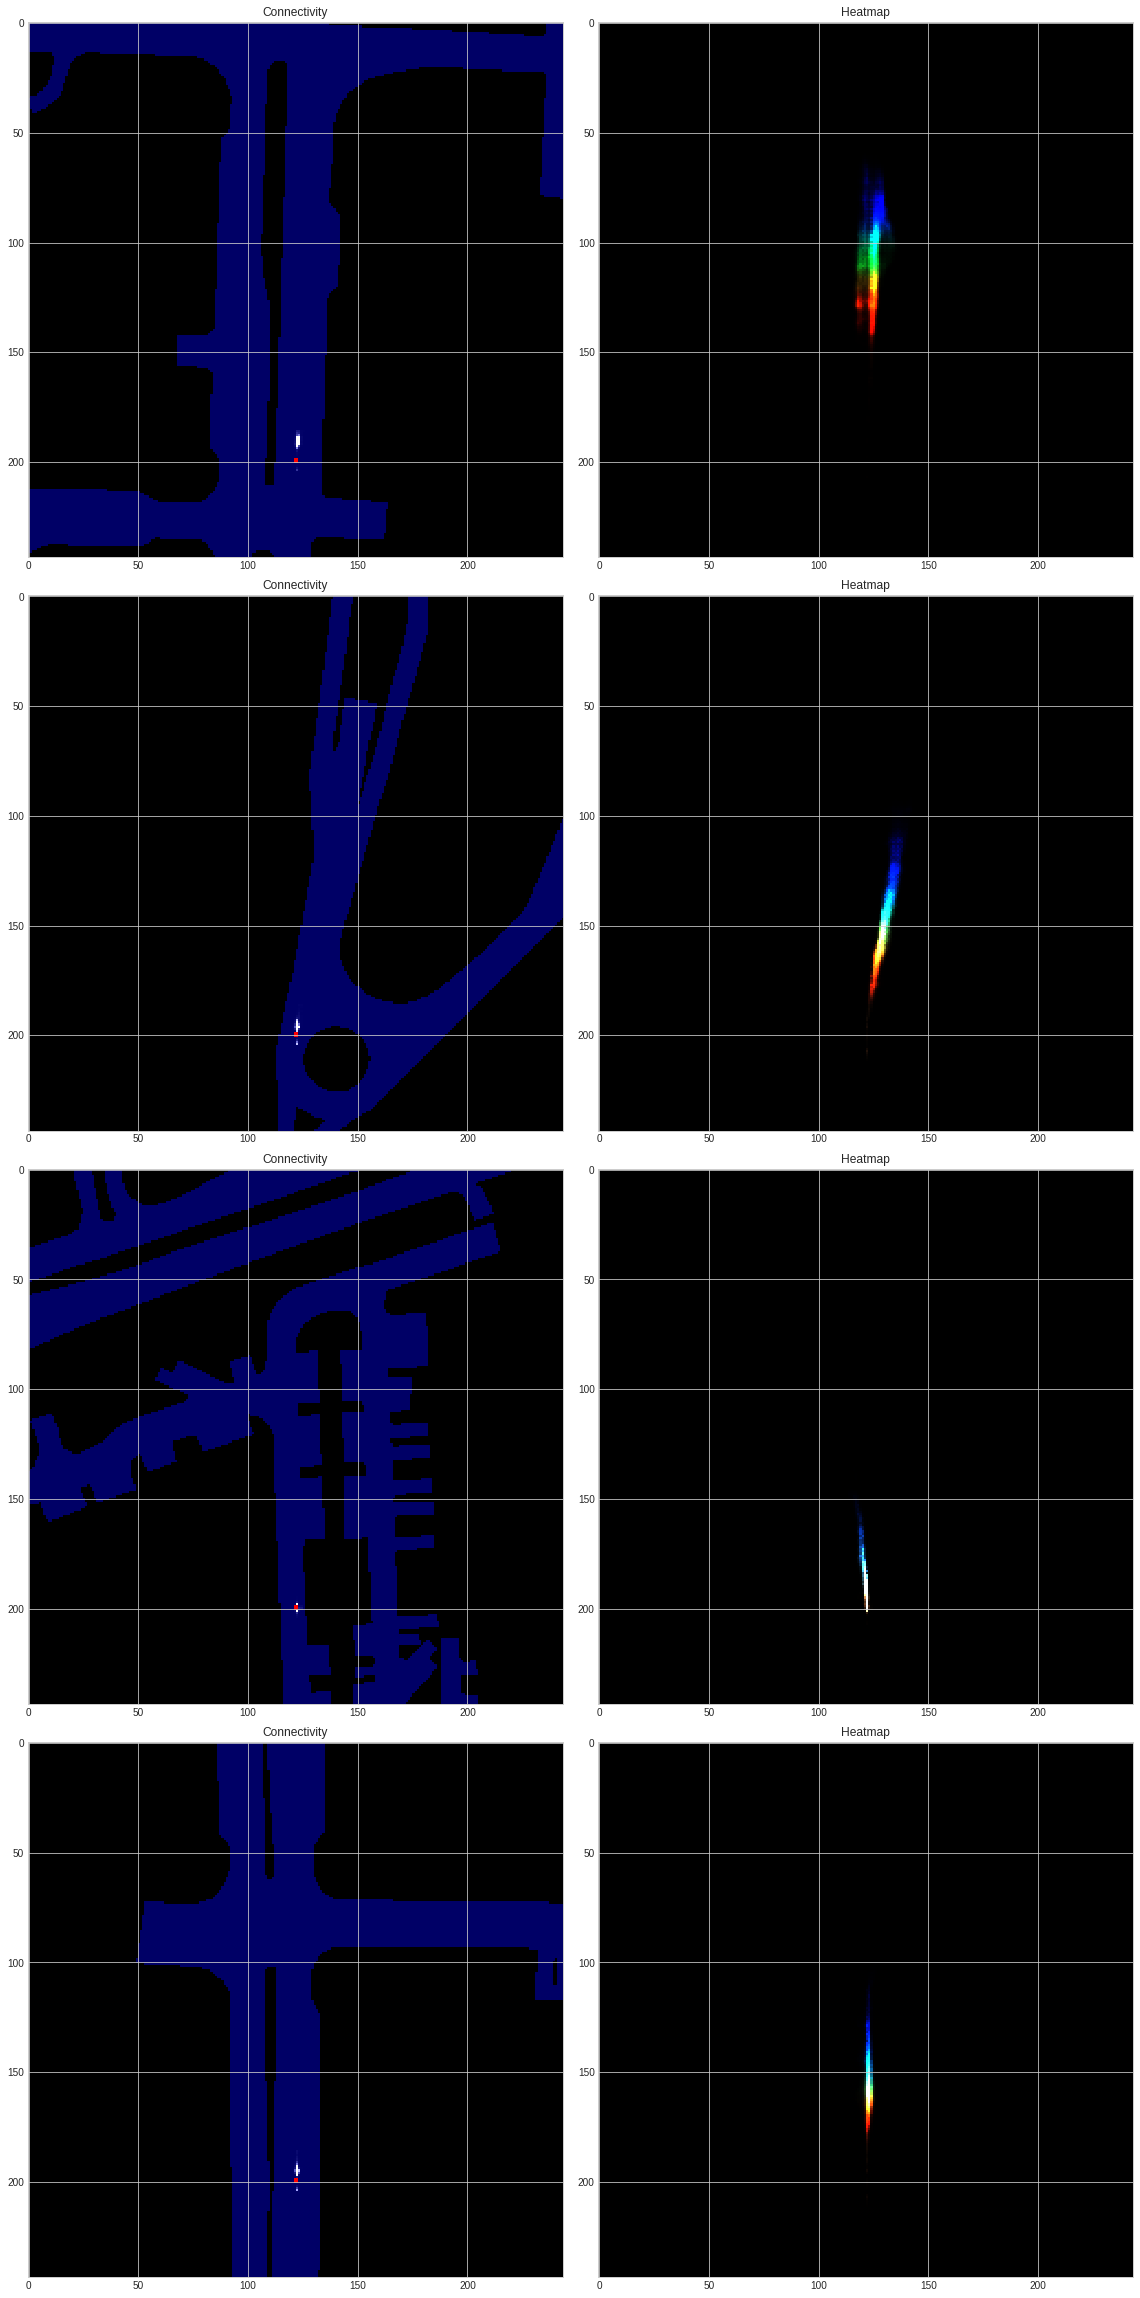

In [11]:
from models.decoders.ram_decoder import get_index,get_dense
self=trainer.model.aggregator
def get_heatmap(predictions,mask):
    if self.agg_type=='global':
        nodes_2D=get_index(predictions['pred'],mask)
        dense_pred=get_dense(predictions['pred'],nodes_2D,self.H,self.W).squeeze(1).clone().detach()
    else:
        dense_pred=predictions['pred'].clone().detach()
    heatmap=torch.cat((dense_pred[:,-5].unsqueeze(1),dense_pred[:,-3].unsqueeze(1),dense_pred[:,-1].unsqueeze(1)),dim=1)
    return heatmap.permute(0,2,3,1).cpu()
def visualize_connectivity(point,connectivity,mask,predictions):
    max_num=max(mask.sum(dim=1))
    init_pos=torch.zeros([self.H,self.W]).to(connectivity.device)
    init_pos[point[0],point[1]]=1
    state=init_pos.view(-1)
    fig, ax = plt.subplots(mask.shape[0], 2, figsize=(16, 8*mask.shape[0]))
    fig.tight_layout()
    if self.agg_type=='global':
        graphs=torch.empty([0,1,max_num]).to(connectivity.device)
        for i in range(mask.shape[0]):
            print(mask.view(mask.shape[0],self.H,self.W)[i,point[0],point[1]])
            reduced_state=((init_pos.view(-1))[mask[i]]).to_sparse()
            aug_state=torch.cat((reduced_state, torch.sparse_coo_tensor(torch.empty([1,0]), [], [max_num - reduced_state.size(0),]).to(connectivity.device)), 0).unsqueeze(0)
            reduced_graph=(aug_state.to_dense()@connectivity[i]).unsqueeze(1)
            graphs=torch.cat((graphs,reduced_graph),dim=0)
        nodes_2D=get_index(graphs,mask)
        dense_pred=get_dense(graphs,nodes_2D,self.H,self.W).squeeze(1).clone().detach().unsqueeze(1)
    else:
        init_states=init_pos.repeat(mask.shape[0],1,1).view(mask.shape[0],-1).unsqueeze(-1)
        fold=nn.Fold(output_size=(self.H, self.W), kernel_size=(self.conv_kernel, self.conv_kernel), padding=self.conv_kernel//2, dilation=1, stride=(1, 1))
        unfolded_map=(init_states*connectivity).transpose(-1,-2)
        dense_pred=torch.cat((fold(unfolded_map)[:,:,5:],torch.zeros([mask.shape[0],1,5,self.W],device=mask.device)),dim=2).clone().detach()
    # mask_map=dense_pred.clone()
    # mask_map[mask.view(dense_pred.shape)]=0.01
    # dense_pred+=mask_map
    # print(dense_pred.shape)
    dense_pred=dense_pred.repeat(1,3,1,1)
    dense_pred*=128
    dense_pred[:,2][mask.view(mask.shape[0],self.H,self.W)]+=0.4
    dense_pred[:,1:,point[0]-1:point[0]+1,point[1]-1:point[1]+1]=0
    dense_pred[:,0,point[0]-1:point[0]+1,point[1]-1:point[1]+1]=255
    
    dense_pred=dense_pred.permute(0,2,3,1)
    last_steps=get_heatmap(predictions,mask)*255
    # last_steps[:,1:,point[0]-1:point[0]+1,point[1]-1:point[1]+1]=0
    # last_steps[:,0,point[0]-1:point[0]+1,point[1]-1:point[1]+1]=600
    # print(last_steps.shape)
    # print(dense_pred)
    for i in range(mask.shape[0]):
        # print(dense_pred[i].shape)

        ax[i, 0].imshow(dense_pred[i].cpu())
        ax[i, 0].set_title('Connectivity')
        ax[i, 1].imshow(last_steps[i])
        ax[i, 1].set_title('Heatmap')

    
visualize_connectivity(self.compensation,agg_feat['node_connectivity'],agg_feat['under_sampled_mask'],predictions)

In [10]:
inputs= agg_feat
self=trainer.model.decoder
attn_output_weights = inputs['node_connectivity']
init_states=inputs['initial_states']

if 'under_sampled_mask' in inputs:
    mask=inputs['under_sampled_mask']
else:
    mask=None
if self.output_traj:
    target_encodings = inputs['target_encodings']
    map_feature=inputs['feature'].permute(0,2,3,1)

In [12]:
torch.cuda.empty_cache()
predictions=torch.empty([init_states.shape[0],0,init_states.shape[-1]],device=attn_output_weights.device)
prev_states=init_states.unsqueeze(1).to_dense()
for step in range(self.horizon):
    predictions=torch.cat((predictions,torch.bmm(prev_states,attn_output_weights)),dim=1)
    prev_states=predictions[:,step].unsqueeze(1)

In [14]:
from models.decoders.ram_decoder import get_dense,get_index
nodes_2D=get_index(predictions[:,-1].unsqueeze(1),mask,self.H,self.W)
dense_pred=get_dense(predictions[:,-1].unsqueeze(1),nodes_2D,self.H,self.W)

In [ ]:
traj_idx=0
idx=5
import matplotlib.pyplot as plt
gt_map=predictions['pred'][:,-1].detach()
mask_map=gt_map.clone()
mask_map[predictions['mask'].view(gt_map.shape)]=0.005
gt_map+=mask_map
plt.imshow(gt_map[idx].squeeze(0).cpu())
plt.show()


In [ ]:
# print(predictions['pred'].shape)
normalized_pred=predictions['pred']/(torch.max(predictions['pred'].detach(),dim=-1,keepdim=True)[0])
print(torch.max(predictions['pred'],dim=-1,keepdim=True)[0])
print(torch.max(normalized_pred,dim=-1,keepdim=True)[0])

In [60]:
focal=trainer.losses[0]
focal.horizon=12

In [ ]:
traj_idx=0
idx=0
import matplotlib.pyplot as plt
from models.decoders.ram_decoder import get_index,get_dense
gt_map=trainer.losses[0].generate_gtmap(predictions['traj'][:,traj_idx].view(predictions['traj'].shape[0],-1,predictions['traj'].shape[-1]).clone().detach(),predictions['mask'],visualize=True)
gt_map=torch.clamp(torch.sum(gt_map,dim=1,keepdim=True),0.0,1.0)
mask_map=gt_map.clone()
mask_map[predictions['mask'].view(gt_map.shape)]=0.005
gt_map+=mask_map
gt_map=gt_map.repeat(1,3,1,1)
gt_map*=127
endpoints=predictions['endpoints']
for batch in range(gt_map.shape[0]):
    for i,point in enumerate(endpoints[batch]):
        if i== traj_idx:
            x,y=point
            gt_map[batch,-1,max(0,x-2):min(x+3,trainer.losses[0].H),max(0,y-2):min(trainer.losses[0].W,y+3)]=255
            gt_map[batch,:-1,max(0,x-2):min(x+3,trainer.losses[0].H),max(0,y-2):min(trainer.losses[0].W,y+3)]=0
        else:
            x,y=point
            gt_map[batch,0,max(0,x-1):min(x+1,trainer.losses[0].H),max(0,y-1):min(trainer.losses[0].W,y+1)]=255
            gt_map[batch,1:,max(0,x-1):min(x+3,trainer.losses[0].H),max(0,y-1):min(trainer.losses[0].W,y+1)]=0

gt_map=gt_map.permute(0,2,3,1)
# normalize_factor,_=torch.max(dense_pred.view(dense_pred.shape[0],-1),dim=-1)
plt.imshow(gt_map[idx].cpu())
plt.show()
# plt.imshow(mask[idx])
# plt.show()
# gt_map.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


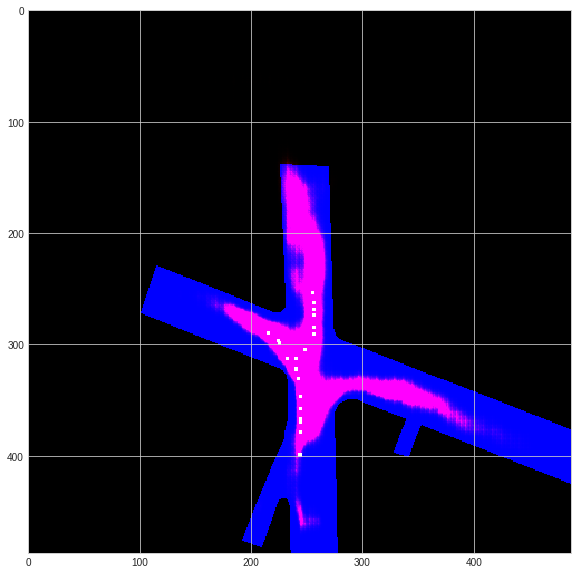

In [17]:
idx=1
fde_sampler=trainer.model.decoder.endpoint_sampler
endpoints,_ = fde_sampler(predictions['pred'])
endpoints=endpoints.long()
mask_map=predictions['mask'].unsqueeze(1).clone().detach().float()
prob=predictions['pred'][:,-1].clone().detach().unsqueeze(1)*255
heatmap=torch.cat((prob,torch.zeros_like(prob),mask_map*10),dim=1)
origin=torch.round(trainer.losses[0].compensation).int()
heatmap[:,:,origin[0]-2:origin[0]+2,origin[1]-2:origin[1]+2]=20
for point in endpoints[idx]:
    heatmap[:,:,point[0]-1:point[0]+2,point[1]-1:point[1]+2]=60
plt.figure(figsize = (10,10))
plt.imshow(heatmap[idx].permute(1,2,0).cpu())
plt.show()

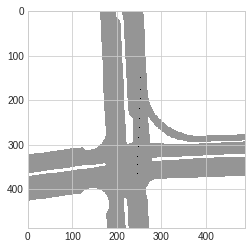

In [24]:
idx=0
# traj_idx=0
import matplotlib.pyplot as plt
from models.decoders.ram_decoder import get_index,get_dense
gt_map=trainer.losses[0].generate_gtmap(data['ground_truth']['traj'],predictions['mask'],visualize=True)
gt_map=torch.sum(gt_map,dim=1,keepdim=True)
mask_map=torch.zeros_like(gt_map)
mask_map[predictions['mask'].view(gt_map.shape)]=1
gt_map+=mask_map
# gt_map=gt_map.permute(0,2,3,1)
# normalize_factor,_=torch.max(dense_pred.view(dense_pred.shape[0],-1),dim=-1)
plt.imshow(gt_map[idx].squeeze(0).cpu())
plt.show()

In [15]:
self=trainer.model.decoder
trajs=predictions['traj']
heatmaps=predictions['pred']
mask=agg_feat['under_sampled_mask']
shape=[mask.shape[0],self.horizon,self.H,self.W]
swapped=torch.zeros_like(trajs)
swapped[:,:,:,0],swapped[:,:,:,1]=-trajs[:,:,:,1],trajs[:,:,:,0]
coord=torch.round(swapped/self.resolution+self.compensation.to(swapped.device))
coord=torch.clamp(coord,0,shape[-1]).long()
coord.device


device(type='cuda', index=0)

In [16]:
horizon=coord.shape[-2]
B=coord.shape[0]
x_coord,y_coord=torch.meshgrid(torch.arange(B,device=coord.device), 
                            torch.arange(horizon,device=coord.device))
indices_front=torch.cat([x_coord.unsqueeze(-1),y_coord.unsqueeze(-1)],dim=-1).long().unsqueeze(1).repeat(1,coord.shape[1],1,1)

# indices=torch.cat((indices_front,coord),dim=-1)
indices_front.device

device(type='cuda', index=0)

In [14]:
indices=torch.cat((indices_front,coord),dim=-1).long()
indices.device

device(type='cpu')

In [17]:
from models.decoders.ram_decoder import get_dense,get_index
nodes_2D=get_index(heatmaps,mask,self.H,self.W)
dense_pred=get_dense(heatmaps,nodes_2D,self.H,self.W)
# dense_pred.device
dense_pred.device

device(type='cuda', index=0)

In [ ]:
ind0=indices.view(-1,4)[:,0]
ind1=indices.view(-1,4)[:,1]
ind2=indices.view(-1,4)[:,2]
ind3=indices.view(-1,4)[:,3]
ind1


In [31]:
probs=dense_pred[ind0,ind1,ind2,ind3].view(B,coord.shape[1],horizon).sum(-1)

In [35]:
probs.sort(descending=True)

torch.return_types.sort(
values=tensor([[1.0372, 0.8492, 0.7616, 0.6335, 0.6223, 0.4670, 0.4462, 0.3702, 0.3455,
         0.3272, 0.3265, 0.3232, 0.2768, 0.2766, 0.2643, 0.2563, 0.2272, 0.2249,
         0.2210, 0.2205],
        [0.3282, 0.1116, 0.0635, 0.0494, 0.0465, 0.0298, 0.0283, 0.0281, 0.0262,
         0.0219, 0.0206, 0.0192, 0.0190, 0.0183, 0.0181, 0.0170, 0.0163, 0.0162,
         0.0159, 0.0148]], grad_fn=<SortBackward>),
indices=tensor([[ 5,  4,  6,  2,  0, 12,  1, 10,  9, 13,  3, 16, 11,  7, 17,  8, 18, 19,
         14, 15],
        [ 2,  0,  1,  4, 15, 13,  9,  6,  3, 17,  7, 19,  5,  8, 10, 11, 12, 14,
         18, 16]]))

In [10]:
predictions['yaw'].shape

torch.Size([32, 34, 1])

In [25]:
encodings['target_agent_encoding'].keys()

dict_keys(['hist', 'future', 'time_query', 'map_info'])

In [10]:

with profile( profile_memory=True, record_shapes=True, use_cuda=True) as prof:
   focal=trainer.losses[0]
   # loss=focal.compute({'pred':predictions,'mask':mask_map},gt_test)
   loss_val=focal.compute(predictions,gt_test)
   for loss in trainer.losses[1:]:
      loss_val+=loss.compute(predictions,gt_test)
   # loss+=trainer.losses[2].compute(predictions,gt_test)
print(prof.key_averages().table(sort_by="cuda_time", row_limit=10))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::index         4.18%     528.681us        15.50%       1.962ms     326.959us     605.183us         5.01%       1.964ms     327.339us           0 b           0 b       3.00 Kb      -4.00 Kb             6  
             aten::index_put_         1.24%     157.422us        15.37%       1.945ms 

In [14]:
ade=trainer.losses[1]
loss=ade.compute(predictions,gt_test)

In [20]:
from math import exp
window_size=9
gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*1.5**2)) for x in range(window_size)])
gauss

tensor([0.0286, 0.1353, 0.4111, 0.8007, 1.0000, 0.8007, 0.4111, 0.1353, 0.0286])

In [26]:
ade.compute(predictions,gt_test)

tensor(39.9779, device='cuda:0', grad_fn=<MeanBackward0>)

In [12]:
torch.cuda.empty_cache()

In [11]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True, use_cuda=True) as prof:
   loss_val.backward()
print(prof.key_averages().table(sort_by="cuda_time", row_limit=10))

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            CudnnRnnBackward         0.21%     425.351us         9.60%      19.503ms       2.786ms     428.016us         0.21%      19.503ms       2.786ms           0 b           0 b       1.54 Mb    -233.50 Kb             7  
                   aten::_

In [12]:
total_norm=0
for p in trainer.model.encoder.a_n_att.parameters():
    try:
        # print(p.shape)
        param_norm = p.grad.data.norm(2)
        if torch.isnan(param_norm):
            print(p.grad.data.shape)
    except:
        print('param_not_used')
        # raise NotImplementedError()
    total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)

In [33]:
predictions['mask'].sum(-1)


tensor([3181, 4249, 4796, 3145], device='cuda:0')

In [34]:
inputs = agg_feat
attn_output_weights = inputs['node_connectivity']
init_states=inputs['initial_states']


mask=inputs['under_sampled_mask']
target_encodings = inputs['target_encodings']
map_feature=inputs['feature'].permute(0,2,3,1)

In [35]:
torch.cuda.empty_cache()
predictions=torch.empty([init_states.shape[0],0,init_states.shape[-1]],device=attn_output_weights.device)
prev_states=init_states.unsqueeze(1).to_dense()

for step in range(12):
    predictions=torch.cat((predictions,torch.bmm(prev_states,attn_output_weights)),dim=1)
    prev_states=predictions[:,step].unsqueeze(1)

torch.cuda.empty_cache()

In [36]:
map_extent= [-61, 61, -22, 100]
from models.decoders.ram_decoder import get_dense,get_index
nodes_2D=get_index(predictions[:,-1].unsqueeze(1),mask)
dense_pred=get_dense(predictions[:,-1].unsqueeze(1),nodes_2D,122,122)
endpoints,confidences = trainer.model.decoder.endpoint_sampler(dense_pred)
endpoints=endpoints.long()
concat_feature=torch.empty([0,12,90],device=attn_output_weights.device)
x_coord,y_coord=torch.meshgrid(torch.arange(map_extent[-1],map_extent[-2],-1), ##### SHould be changed when image size changes
                                torch.arange(map_extent[0],map_extent[1],1))
indices=torch.cat([x_coord.unsqueeze(-1),y_coord.unsqueeze(-1)],dim=-1).to(attn_output_weights.device)
for batch_idx in range(len(dense_pred)):
    map_feat = (map_feature[batch_idx])[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]]
    diff = indices[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]].float()

    feature=torch.cat([map_feat,trainer.model.decoder.diff_encoder(diff),target_encodings[batch_idx].repeat(trainer.model.decoder.endpoint_sampler._n_targets,1)],dim=-1).unsqueeze(0)
    concat_feature=torch.cat([concat_feature,feature],dim=0)

In [ ]:
print(torch.cuda.memory_summary(0))

In [ ]:
pred=predictions['pred']
mask=predictions['mask']
traj_gt = gt_test['traj']

In [ ]:
import torch.nn.functional as F
with profile( profile_memory=True, record_shapes=True) as prof:
    swapped=torch.zeros_like(traj_gt).to(pred.device)
    swapped[:,:,0],swapped[:,:,1]=-traj_gt[:,:,1],traj_gt[:,:,0]
    coord=torch.round(swapped/trainer.losses[0].resolution+trainer.losses[0].compensation).int()
    coord=torch.clamp(coord,0,122)
    gt_map=torch.zeros([6,12,122,122],device=pred.device)
    for batch in range(6):
        for t in range(12):
            x,y=coord[batch,t]
            gt_map[batch,t,x,y]=1##Only one ground truth in each heatmap layer
    gs_map=F.conv2d(gt_map, trainer.losses[0].window, padding = trainer.losses[0].window_size//2, groups = trainer.losses[0].horizon)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    loss_mask = (reduced_gts == 1).float()
    pred_heatmap = torch.clamp(pred, min=1e-4)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    loss=-torch.sum(
                    torch.pow(pred_heatmap - reduced_maps, 2) * (
                    loss_mask * torch.log(pred_heatmap)
                    +
                    (1-loss_mask) * (torch.pow(1 - reduced_maps, 4) * torch.log(1 - pred_heatmap))
                )
            )
    loss.backward()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True) as prof:
    trainer.optimizer.step()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))


In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    gs_map=gs_map.view([6,12,-1])
    gt_map=gt_map.view([6,12,-1])
    max_num=max(mask.sum(dim=1))
    reduced_maps=[]
    reduced_gts=[]
    for i,batch in enumerate(gs_map):
        reduced_map=batch[mask[i].repeat(12,1)].view(12,-1)
        reduced_gt=gt_map[i][mask[i].repeat(12,1)].view(12,-1)
        aug_map=torch.cat((reduced_map, torch.zeros(12,max_num - reduced_map.size(1),device=pred.device)), -1)
        aug_gt=torch.cat((reduced_gt, torch.zeros(12,max_num - reduced_map.size(1),device=pred.device)), -1)
        reduced_maps.append(aug_map.unsqueeze(0))
        reduced_gts.append(aug_gt.unsqueeze(0))
    reduced_maps=torch.cat(reduced_maps,dim=0).to(pred.device)
    reduced_gts=torch.cat(reduced_gts,dim=0).to(pred.device)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
reduced_gts.sum()

In [ ]:
def get_index(pred,mask):
    x_coord,y_coord=torch.meshgrid(torch.arange(0,122,1),
                                torch.arange(0,122,1))
    nodes_candidates=torch.cat((x_coord.unsqueeze(0),y_coord.unsqueeze(0)),dim=0).view(2,-1).T
    nodes_2D=torch.zeros([mask.shape[0],pred.shape[-1],2])
    for i in range(mask.shape[0]):
        nodes_batch=nodes_candidates[mask[i]]
        nodes_2D[i,:nodes_batch.shape[0]]=nodes_batch
    return nodes_2D.int().permute(0,2,1).to(pred.device)
nodes_2D=get_index(pred,mask)
nodes_2D.shape

In [ ]:
def get_dense(pred,nodes_2D,H,W):
    dense_rep=torch.empty(0,pred.shape[1],H,W,device=pred.device)
    for batch in range(pred.shape[0]):
        batch_heatmap=torch.empty(0,H,W,device=pred.device)
        for step in range(pred.shape[1]):
            heatmap=torch.sparse_coo_tensor(nodes_2D[batch],pred[batch,step],(122,122))
            batch_heatmap=torch.cat((batch_heatmap,heatmap.to_dense().unsqueeze(0)),dim=0)
        dense_rep=torch.cat((dense_rep,batch_heatmap.unsqueeze(0)),dim=0)
    return dense_rep
dense_rep=get_dense(pred,nodes_2D,122,122)

In [ ]:
predictions['probs']=predictions['prob']

In [ ]:


with profile( profile_memory=True, record_shapes=True) as prof:

# loss=pred.sum()
    loss=focal.compute(predictions,gt_test)
    loss+=ade.compute(predictions,gt_test)
    loss.backward()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
trainer.model.aggregator

In [ ]:
pred = predictions['pred']
mask_da = predictions['mask'].view(-1,pred.shape[-2],pred.shape[-1]).unsqueeze(1)
ground_truth = gt_test
traj_gt = ground_truth['traj'] if type(ground_truth) == dict else ground_truth
true_heatmap,gs_map = focal.generate_gtmap(traj_gt,pred.shape)
gs_map=gs_map*mask_da
mask = (true_heatmap == 1).float()
pred_heatmap = torch.clamp(pred, min=1e-4)

In [ ]:
loss= focal()

In [ ]:
loss.backward()

In [ ]:
pred = predictions['pred']
mask = predictions['mask'].view(-1,pred.shape[-2],pred.shape[-1]).unsqueeze(1)
non_drivable_area_mask=~mask

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(non_drivable_area_mask[0,0].cpu())
plt.show()
plt.imshow(torch.zeros_like(non_drivable_area_mask[0,0].cpu()))
plt.show()

In [ ]:
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.nuscenes import NuScenes
map_extent=[ -50, 50, -20, 80 ]
img_size=[400,400]
resolution = (map_extent[1] - map_extent[0]) /  img_size[1]
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)
helper=PredictHelper(nusc)
map_rasterizer = StaticLayerRasterizer(helper,
                                        resolution=resolution,
                                        meters_ahead=map_extent[3],
                                        meters_behind=-map_extent[2],
                                        meters_left=-map_extent[0],
                                        meters_right=map_extent[1])

In [ ]:
import torch
target_agent_representation = data_test['target_agent_representation']
surrounding_agent_representation = data_test['surrounding_agent_representation']
map_representation = data_test['map_representation'][0]
mask= data_test['map_representation'][1].type(torch.bool)
mask.shape

In [ ]:
idx=10
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.array(mask[idx]))
plt.show()
plt.imshow(np.array(map_representation[idx]).transpose(1,2,0))

In [ ]:
from models.encoders.raster_encoder import *
encoder=RasterEncoder(cfg['encoder_args'])
# encodings=encoder.forward(data_test)

In [ ]:
encodings['context_encoding']["combined"].shape

In [ ]:
test_tensor=torch.randn([32,20,100,100])
test_walker=LocalWalk(radius=0.2)
test_walker.forward(test_tensor,test_tensor).shape

In [ ]:
from models.library.RasterSampler import *
sampler=Sampler(cfg['train_set_args'],1)

In [ ]:
fake_mask=torch.randn([32,488,488]).ge(0)
nodes_2D=sampler.sample_goals().repeat(32,1,1).type(torch.float32)
mask_under=(sampler.sample_mask(mask))
attn_mask=~mask_under.unsqueeze(-1).repeat(2,1,256)
print(attn_mask.shape)
print(mask.shape)
print(nodes_2D.shape)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(mask[0]))
plt.show()
plt.imshow(np.array(~mask_under[0].view(122,122)))
plt.show()

In [2]:
with open("configs/preprocess_nuscenes_occ.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [3]:
from datasets.nuScenes.nuScenes_graphs_occ import NuScenesGraphs_OCC
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)


Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.895 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [4]:
from datasets.nuScenes.prediction import PredictHelper_occ
helper=PredictHelper_occ(nusc)
graph_extractor=NuScenesGraphs_OCC('extract_data','preprocess_graph_mini_test',cfg['train_set_args'],helper)

6.0
19.5


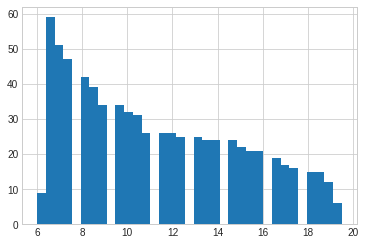

In [54]:
self=graph_extractor
future_lengths=[]
for idx,token in enumerate(self.token_list):
    future_lengths.append(len(self.get_target_agent_future(idx))*0.5)
plt.hist(future_lengths,bins=35)
print(min(future_lengths))
print(max(future_lengths))

1.5
16.0


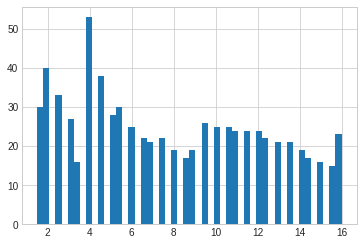

In [6]:
plt.hist(graph_extractor.time_lengths,bins=50)
print(min(graph_extractor.time_lengths))
print(max(graph_extractor.time_lengths))

In [1]:
import numpy as np
from pyquaternion import Quaternion
from nuscenes.eval.common.utils import quaternion_yaw, angle_diff
from nuscenes.prediction.input_representation.static_layers import correct_yaw
def get_surrounding_agent_representation(self, idx: int, time: float):
        """
        Extracts surrounding agent representation
        :param idx: data index
        :return: ndarrays with surrounding pedestrian and vehicle track histories and masks for non-existent agents
        """

        # Get vehicles and pedestrian histories for current sample
        
        vehicles = self.get_agents_of_type(idx, 'vehicle', time)
        pedestrians = self.get_agents_of_type(idx, 'human', time)

        # Discard poses outside map extent
        vehicles = self.discard_poses_outside_extent(vehicles)
        pedestrians = self.discard_poses_outside_extent(pedestrians)
        return vehicles,pedestrians
        # While running the dataset class in 'compute_stats' mode:
        if self.mode == 'compute_stats':
            return len(vehicles), len(pedestrians)

        # Convert to fixed size arrays for batching
        if self.use_home:
            vehicles = self.list_to_tensor(vehicles, self.max_vehicles, int(self.t_h * 2 + 1), 5,True)
            pedestrians = self.list_to_tensor(pedestrians, self.max_pedestrians, int(self.t_h * 2 + 1), 5,True)

            surrounding_agent_representation = {
                'vehicles': vehicles,
                'pedestrians': pedestrians
            }
        else:
            vehicles, vehicle_masks = self.list_to_tensor(vehicles, self.max_vehicles, int(self.t_f * 2 + 1), 4,False)
            pedestrians, pedestrian_masks = self.list_to_tensor(pedestrians, self.max_pedestrians, int(self.t_f * 2 + 1), 4,False)

            surrounding_agent_representation = {
                'vehicles': vehicles,
                'vehicle_masks': vehicle_masks,
                'pedestrians': pedestrians,
                'pedestrian_masks': pedestrian_masks
            }
        if self.use_raster:
            i_t, s_t = self.token_list[idx].split("_")
            img = self.agent_rasterizer.make_representation(i_t, s_t)
            img = np.moveaxis(img, -1, 0)
            img = img.astype(float) / 255
            surrounding_agent_representation['image']=img

        return surrounding_agent_representation

In [71]:
    def get_target_agent_representation(self, idx: int, time: float) :
        """
        Extracts target agent representation
        :param idx: data index
        :return hist: track history for target agent, shape: [t_h * 2, 5]
        """
        i_t, s_t = self.token_list[idx].split("_")

        # x, y co-ordinates in agent's frame of reference
        coords,global_yaw,time_past = self.helper.get_past_for_agent(i_t, s_t, seconds=self.t_h, in_agent_frame=False,add_yaw_and_time=True)
        origin = self.get_target_agent_global_pose(idx)
        past_hist=np.zeros([1,4])
        for xy,r,t in zip(coords,global_yaw,time_past):
            local_pose = self.global_to_local(origin, (xy[0], xy[1], quaternion_yaw(Quaternion(r))))
            past_hist=np.concatenate((past_hist,np.asarray([local_pose.__add__((t,))])),0)
        # Zero pad for track histories shorter than t_h
        hist=[past_hist[::-1]]
        
        # Get future information
        coords_fut,global_yaw_fut,time_fut = self.helper.get_future_for_agent(i_t, s_t, seconds=self.t_h+time, in_agent_frame=False,add_yaw_and_time=True)
        sep_idx= np.searchsorted(time_fut, time-0.1)
        future_rec=np.empty([0,4])
        for xy,r,t in zip(coords_fut[sep_idx:],global_yaw_fut[sep_idx:],time_fut[sep_idx:]):
            local_pose = self.global_to_local(origin, (xy[0], xy[1], quaternion_yaw(Quaternion(r))))
            future_rec=np.concatenate((future_rec,np.asarray([local_pose.__add__((t,))])),0)
        future=[future_rec[::-1]]
        
        gt_poses=np.empty([0,3])
        time_query=[]
        for xy,r,t in zip(coords_fut[:sep_idx],global_yaw_fut[:sep_idx],time_fut[:sep_idx]):
            local_pose = np.asarray([self.global_to_local(origin, (xy[0], xy[1], quaternion_yaw(Quaternion(r))))])
            gt_poses= np.concatenate((gt_poses,local_pose),0)
            time_query.append([np.array([t,t/time])])
        time_query=np.concatenate(time_query,axis=0)
        hist, hist_masks = self.list_to_tensor(hist, 1, self.t_h * 2 + 1, 4,False)
        future, future_masks = self.list_to_tensor(future, 1, self.t_h * 2 + 1, 4,False)
        # gt_traj=np.flip(gt_coords,0)
        history={'traj':np.squeeze(hist,0),'mask':np.squeeze(hist_masks,0)}
        future={'traj':np.squeeze(future,0),'mask':np.squeeze(future_masks,0)}
        target_representation={'history':history,'future':future,'time_query':time_query}
        return target_representation,gt_poses

In [5]:
data,ground_truth=graph_extractor.get_inputs(0)

In [10]:
data['map_representation'].keys()

dict_keys(['lane_node_feats', 'lane_node_masks', 's_next', 'edge_type', 'lane_ctrs'])

In [39]:
idx=0
i_t, s_t = graph_extractor.token_list[idx].split("_")
map_name = graph_extractor.helper.get_map_name_from_sample_token(s_t)
map_api = graph_extractor.maps[map_name]

# Get agent representation in global co-ordinates
global_pose = graph_extractor.get_target_agent_global_pose(idx)

# Get lanes around agent within map_extent
lanes = graph_extractor.get_lanes_around_agent(global_pose, map_api)

# Get relevant polygon layers from the map_api
polygons = graph_extractor.get_polygons_around_agent(global_pose, map_api)

# Get vectorized representation of lanes
lane_node_feats, lane_ids = graph_extractor.get_lane_node_feats(global_pose, lanes, polygons)


In [43]:
len(lane_node_feats)

95

In [42]:
lane_node_feats, lane_ids = graph_extractor.discard_poses_outside_extent(lane_node_feats, lane_ids)

In [30]:
e_succ = graph_extractor.get_successor_edges(lane_ids, map_api)
e_prox = graph_extractor.get_proximal_edges(lane_node_feats, e_succ)

In [50]:
lane_node_feats = graph_extractor.add_boundary_flag(e_succ, lane_node_feats)
lane_node_feats[0].shape

(6, 6)

In [36]:

num_nbrs = [len(e_succ[i]) + len(e_prox[i]) for i in range(len(e_succ))]
max_nbrs = max(num_nbrs) if len(num_nbrs) > 0 else 0
num_nodes = len(lane_node_feats)


In [37]:
print('num_nbrs',(num_nbrs))
print('max_nbrs',max_nbrs)
print('num_nodes',num_nodes)

num_nbrs [6, 1, 1, 5, 7, 6, 3, 2, 4, 3, 4, 2, 1, 2, 2, 5, 3, 5, 2, 3, 1, 4, 6, 4, 4, 2, 3, 5, 7, 4, 5, 3, 4, 6, 4, 4, 2, 3, 4, 4, 5, 8, 5, 3, 7, 4, 6, 5, 4, 2, 3, 5, 7, 6, 6, 2, 4, 5, 5, 3, 5, 7, 5, 3, 5, 4, 2, 3, 7, 5, 5, 4, 1, 4, 2, 5, 4, 6, 7, 5, 3, 5, 2, 2, 4, 5, 3, 6, 5, 4, 5, 9, 4, 6, 3]
max_nbrs 9
num_nodes 172


In [ ]:
s_next, edge_type = graph_extractor.get_edge_lookup(e_succ, e_prox)

In [ ]:
from numpy import linalg as LA
lengths=[]
segment_lengths=[]
for idx in range(len(lane_node_feats)):
    lengths.append(LA.norm(lane_node_feats[idx][1:,:2]-lane_node_feats[idx][:-1,:2],axis=1).sum())
    segment_lengths.append(LA.norm(lane_node_feats[idx][1:,:2]-lane_node_feats[idx][:-1,:2],axis=1)[0])
print(lengths)
print(segment_lengths)

In [48]:
lane_node_feats[0]

array([[-1.42395266e+00,  5.90538053e+01,  5.70842960e-02,
         0.00000000e+00,  0.00000000e+00],
       [-1.47032578e+00,  5.98723220e+01,  5.53921665e-02,
         0.00000000e+00,  0.00000000e+00],
       [-1.51451804e+00,  6.06909591e+01,  5.24686033e-02,
         0.00000000e+00,  0.00000000e+00],
       [-1.55631679e+00,  6.15097219e+01,  4.95450402e-02,
         0.00000000e+00,  0.00000000e+00],
       [-1.59572166e+00,  6.23286035e+01,  4.66214771e-02,
         0.00000000e+00,  0.00000000e+00],
       [-1.63273230e+00,  6.31475967e+01,  4.36979139e-02,
         0.00000000e+00,  0.00000000e+00]])

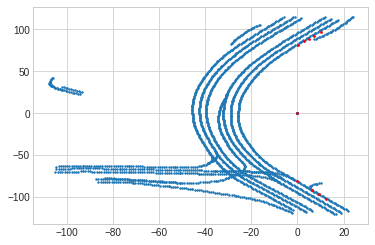

In [20]:
import numpy as np
batch=0
prev_feat=np.empty([0,6])
for idx in range(lane_node_feats.shape[1]):
    feat=lane_node_feats[batch,idx].cpu()
    prev_feat=np.r_[prev_feat,feat]

import matplotlib.pyplot as plt
x=prev_feat[:,0]
y=prev_feat[:,1]
plt.scatter(x,y,s=2)

motion=np.array(concat[batch].cpu())

x=motion[:,0]
y=motion[:,1]
plt.scatter(x,y,s=3,color='r')


In [14]:
data['map_representation']['lane_node_feats'].shape

(218, 20, 6)

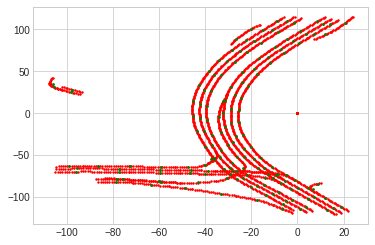

In [32]:
x,y=data_test['map_representation']['lane_node_feats'][batch,:,:,0].flatten(),data_test['map_representation']['lane_node_feats'][batch,:,:,1].flatten()
plt.scatter(x.cpu(),y.cpu(),s=2,color='r')


x,y=data_test['map_representation']['lane_ctrs'][batch,:,0],data_test['map_representation']['lane_ctrs'][batch,:,1]
plt.scatter(x.cpu(),y.cpu(),s=3,color='g')

In [31]:
data_test['map_representation']['lane_ctrs'].shape

torch.Size([36, 296, 2])

In [15]:
hist


tensor([[[  85.0252, -107.9808,    0.6942,   -2.0000],
         [  80.0219, -102.3110,    0.6983,   -1.5002],
         [  75.0120,  -96.6339,    0.7025,   -0.9997],
         [  70.0941,  -90.8804,    0.7066,   -0.4993],
         [  65.2459,  -84.9334,   -0.7939,    0.0000]],

        [[  -6.5201,   -7.4377,   -1.2864,   -1.9486],
         [  -5.1718,   -6.9618,   -1.2428,   -1.4487],
         [  -3.9417,   -6.3271,   -1.1338,   -0.9489],
         [  -2.9003,   -5.6441,   -1.0357,   -0.4993],
         [  -1.8284,   -4.7707,    1.6753,    0.0000]],

        [[  30.9018,  -21.8958,    1.8666,   -1.8989],
         [  29.4595,  -22.3762,    1.8666,   -1.3990],
         [  28.0172,  -22.8566,    1.8666,   -0.8991],
         [  26.5746,  -23.3356,    1.8666,   -0.3992],
         [  25.4232,  -23.7192,   -3.0866,    0.0000]],

        [[ -25.7863,  -28.0576,   -0.7324,   -0.4999],
         [ -23.0704,  -25.2717,    0.6801,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000],
    

In [16]:
future

tensor([[[-8.2116e+01,  1.0817e+02,  6.3683e-01,  1.6500e+01],
         [-7.7983e+01,  1.0231e+02,  6.3683e-01,  1.6000e+01],
         [-7.3736e+01,  9.6514e+01,  6.3683e-01,  1.5500e+01],
         [-6.5246e+01,  8.4933e+01,  6.3683e-01,  1.4501e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.5305e+00,  1.2026e+01, -9.0900e-02,  4.5487e+00],
         [ 2.3673e+00,  9.6022e+00, -1.1998e-01,  4.0489e+00],
         [ 2.1331e+00,  7.1842e+00, -1.4906e-01,  3.5489e+00],
         [ 1.8284e+00,  4.7707e+00, -1.7817e-01,  3.0485e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-3.4701e+01,  3.5543e+01,  6.9020e-01,  1.3948e+01],
         [-2.5423e+01,  2.3719e+01,  6.4660e-01,  1.2449e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.6807e+01,  2.8840e+01, -7.8479e-01, 